<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
# !pip install ydata_profiling

In [2]:
import os
import pickle
import random
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy import stats
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from ydata_profiling import ProfileReport


random.seed(42)
np.random.seed(42)

warnings.filterwarnings("ignore", category=UserWarning)

Classic ML:

*1.  Классификация при сильном дисбалансе классов:*
Методы: Взвешивание классов (class_weight), выбор метрики (Precision, Recall, F1, PR-AUC, ROC-AUC), семплирование (SMOTE, undersampling мажоритарного), изменение порога классификации, использование алгоритмов, устойчивых к дисбалансу (деревья, бустинг).
Ключевая идея: Accuracy бесполезна. Нужно фокусироваться на качестве предсказания миноритарного класса.

2.  Можно ли обучить лог регрессию на MSE?
Технически да, но не нужно. MSE приводит к невыпуклой функции потерь для логистической регрессии, что усложняет оптимизацию (много локальных минимумов). Log Loss (бинарная кросс-энтропия) — выпуклая и соответствует вероятностной интерпретации модели, что ведет к более стабильному и качественному обучению.

3.  Алгоритм построения решающих деревьев, основные гиперпараметры и их влияние:
Алгоритм (жадный): Для каждого узла выбирается признак и порог, которые лучше всего разделяют данные по критерию (энтропия, Джини, MSE). Процесс рекурсивно повторяется.
Гиперпараметры:
    `max_depth`: Макс. глубина. Рост → переобучение, уменьшение → недобучение.
    `min_samples_split/leaf`: Мин. объектов для разделения узла/в листе. Рост → регуляризация, упрощение дерева.
    `max_features`: Макс. число признаков для поиска разделения. Уменьшение → снижение корреляции (важно для леса).

4.  Как работает много классовая классификация?
"Один против всех" (One-vs-Rest): Для каждого из K классов обучается бинарный классификатор "этот класс vs все остальные". Выбирается класс с наибольшей уверенностью.
"Один против одного" (One-vs-One): Обучается K*(K-1)/2 классификаторов на каждой паре классов. Класс выбирается голосованием.
Нативные алгоритмы: Некоторые модели (логистическая регрессия, деревья, градиентный бустинг) поддерживают многоклассовость "из коробки", используя softmax и кросс-энтропийную потерю.

5.  В чем отличие бустинга от градиентного бустинга?
Бустинг (AdaBoost): Каждая новая модель исправляет ошибки предыдущих, уделяя больше внимания неправильно классифицированным объектам через веса объектов. Слабая модель — часто "пень" (неглубокое дерево).
Градиентный бустинг (GBM): Каждая новая модель обучается не на "перевзвешенных" объектах, а на градиентах (остатках/антиградиенте) функции потерь предыдущей ансамблевой модели. Это обобщение, позволяющее использовать разнообразные функции потерь (MSE, LogLoss, Huber).

6.  Bias-Variance Tradeoff:
Смещение (Bias): Ошибка из-за слишком простых предположений модели (недообучение). Высокое смещение → плохо на обучающих данных.
Разброс (Variance): Ошибка из-за чувствительности модели к шуму в данных (переобучение). Высокая дисперсия → хорошо на обучающих, плохо на новых.
Компромисс: Упрощая модель (↑bias, ↓variance), мы увеличиваем смещение, но уменьшаем разброс, и наоборот. Цель — найти баланс, минимизирующий общую ошибку.

7.  Регуляризация, сложность моделей, информационные критерии (AIC, BIC):
Регуляризация: Добавление штрафа за сложность модели в функцию потерь (L1-лассо, L2-ридж). Снижает переобучение, "зануляя" или уменьшая веса.
Информационные критерии: Методы выбора модели, балансирующие качество fit и сложность.
    AIC: `-2*log(правдоподобие) + 2*число_параметров`. Оптимизирует предсказание на новых данных из того же распределения.
    BIC: `-2*log(правдоподобие) + log(N)*число_параметров`. Сильнее штрафует за сложность. Стремится найти "истинную" модель.

8.  Проклятье размерности (причины, следствия, борьба с явлением):
Причина: С ростом числа признаков объем пространства растет экспоненциально, данные становятся чрезвычайно разреженными.
Следствия: Резко падает плотность данных, расстояния между точками становятся бессмысленными, нужен экспоненциально больший объем данных для обучения.
Борьба: Отбор признаков, снижение размерности (PCA, t-SNE), регуляризация, использование моделей, устойчивых к проклятию (деревья, ядерные методы).

9.  Мультиколлинеарность (причины и решения):
Причина: Сильная корреляция между признаками (например, рост и вес).
Проблемы: Неустойчивость оценок коэффициентов (большие стандартные ошибки), сложность интерпретации.
Решения: Отбор признаков (VIF-анализ), объединение коррелированных признаков, регуляризация (L1, L2), метод главных компонент (PCA).

10. Интерпретируемость моделей. Что влияет на интерпретируемость коэффициентов линейной регрессии?
Интерпретируемость — понимание влияния признаков на прогноз.
Для линейной регрессии на интерпретацию коэффициентов влияет:
Масштабирование признаков: Коэффициенты напрямую сравнимы только при одинаковом масштабе (стандартизация).
Мультиколлинеарность: Делает коэффициенты неустойчивыми и неинтерпретируемыми.
Независимость ошибок (гомоскедастичность): Нарушение ведет к неверным стандартным ошибкам и, как следствие, p-values.

TimeSeries:

1.  Компоненты ВР (тренд, сезонность, шум):
Тренд: Долгосрочное направленное движение (рост, спад).
Сезонность: Периодические колебания с фиксированной частотой (день, месяц, год).
Шум (остаток): Случайная, необъяснимая компонента после извлечения тренда и сезонности.

2.  Что такое стационарность и почему она важна для моделей?
Стационарность: Свойства ряда (среднее, дисперсия, автоковариация) не зависят от времени.
Важность: Подавляющее большинство статистических моделей (ARIMA) и их предпосылок (например, для тестов) требуют стационарности. Нестационарный ряд дает ложные закономерности.

3.  Валидация на ВР (как верно настроить train_test_split, как работает кросс-валидация, как избежать data leakage):
Train/Test Split: Разделение хронологически (не случайно!). Test всегда после train.
Кросс-валидация: Используется только скользящее окно (Rolling Window) или расширяющееся окно (Expanding Window). Никакого случайного перемешивания.
Избегание leakage: При создании признаков (лаги, скользящие статистики) расчет должен вестись только на обучающих данных внутри каждого фолда CV. Нельзя использовать будущие данные для предсказания прошлого.

4.  Особенности feature engineering (что такое lag, diff, скользящие окна, автокорреляция и т.д.):
Лаг (Lag): Значение ряда в предыдущий момент времени (`y_{t-1}, y_{t-7}`). Основа для AR-моделей.
Разность (Diff): `y_t - y_{t-1}`. Простейший способ устранения тренда (получение стационарности).
Скользящие окна (Rolling Windows): Статистики (среднее, std, min, max) за последние N периодов. Улавливают локальные изменения.
Автокорреляция (ACF): Корреляция ряда с его собственными лагами. Показывает силу и лаг сезонности/тренда.

5.  Основные статистические модели для работы с ВР:
AR (Авторегрессия): Прогноз как линейная комбинация прошлых значений ряда.
MA (Скользящее среднее): Прогноз как линейная комбинация прошлых ошибок прогноза.
ARIMA: Объединение AR и MA + интегрирование (diff) для работы с нестационарностью.
SARIMA: ARIMA с сезонной компонентой.
ETS (Error, Trend, Seasonality): Экспоненциальное сглаживание, явно моделирующее три компоненты ряда.
Prophet (Meta): Аддитивная модель с трендом, сезонностью и эффектом праздников.

## Пара важных замечаний перед работой:

1. Я применяю автоформаттер black через nbqa (чтобы юпитер тетрадка обрабатывалась корректно), поэтому иногда код выглядит не совсем как человеческий, зато по PEP8 :D
2. В каждом из мест использования LLM я, согласно требованиям, явно это прописываю
3. Из-за особенностей работы ydata_profiling (описано ниже в соответствующем месте), весь ноутбук запущен подряд, кроме блока с как раз выводом дашборда yprofile - он отдельно запускается самым последнем. При выполнении работы я, конечно, запускал его сразу, но чтобы всё в итоге отображалось корректно и красиво, пришлось сделать так.

Благодарю за внимание и за проверку!)

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

`Your answer here` Сиды фиксируем для воспроизводимости результатов

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [3]:
df_train = pd.read_csv(
    "https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv"
)
df_test = pd.read_csv(
    "https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv"
)

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [4]:
for col in df_train:
    if df_train[col].isna().sum():
        print(f"В колонке {col} {df_train[col].isna().sum()} пропусков")

В колонке mileage 202 пропусков
В колонке engine 202 пропусков
В колонке max_power 196 пропусков
В колонке torque 203 пропусков
В колонке seats 202 пропусков


In [5]:
for col in df_test:
    if df_test[col].isna().sum():
        print(f"В колонке {col} {df_test[col].isna().sum()} пропусков")

В колонке mileage 19 пропусков
В колонке engine 19 пропусков
В колонке max_power 19 пропусков
В колонке torque 19 пропусков
В колонке seats 19 пропусков


Видим, что `пропуски есть` как в тренировочном, так и в тестовом датасете. Нужно предусмотреть пайплайн обработки пропусков перед работой любых моделей.

In [6]:
df_train.duplicated().sum()

985

В тренировочном наборе `985 дубликатов`. В тестовом проверять смысла не вижу, так как их в любом случае лучше не трогать.

In [7]:
profile = ProfileReport(df_train, title="Profiling Report")

In [8]:
# profile.to_notebook_iframe()

**Ваш ответ здесь.**

Интересно, что количество дубликатов в дашборде в 2 раза меньше (округлено в большую сторону), нежели в пандасе. Мне стало интересно, что происходит, полез смотреть в гитхабе реализацию подсчета. Увидел много красивого кода, в котором никакие концы быстро найти не удалось, кроме самого классного момента:
![get_duplicates](https://github.com/Aleksekek/HSE_ML/blob/main/HW_1_PRO/saved_plots/duplicates.png?raw=true)  
В общем, просто оставляем это на совести разработчиков.

Также у меня почему-то из-за этой прекрасной визуализации потом не работает seaborn, но это, видимо, тоже просто принимаем таким, какое оно есть...

Достаточно много пропущенных, количество дубликатов не так критично.

По **EDA**: 
* Самый популярный год - 2017
* Медианная цена продажи - 450000 денежных единиц, при том в столбце, судя по гистаграмме, есть очень сильные выбросы
* Аналогичная ситуация по выбросам и у столбца с пробегом. В то время, как медиана - 60000, максимкальное значение доходит до 2360457, что больше почти в 40 раз.
* Из корреляций можно сделать такие основные выводы - цена обратно коррелирует с пробегом. Это логически закономерно, чем выше износ, тем ниже цена.
* Также и корреляций видим, что пробег достаточно сильно обратно коррелирует с годом. Тоже логично - чем старше машина, тем больше на ней успели поездить.
* Наиболее же выраженной прямой корреляцией видим год выпуска и цену продажи. Тоже соотносится с логикой по причинам, упомянутых в двух предыдущих пунктах.

Из прикладного, на что важно обратить внимание при обработке датасета - в датасете есть несколько столбцов, являющихся текстовыми, но на самом деле их стоит обработать и сделать числовыми. В том числе:
* mileage
* engine
* max_power
* torque  

В каждом из этих столбцов в значения записаны непосредственно само число плюс его единица измерения. Убрав ее, получим числовые столбцы.

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

#### Для трейна

In [9]:
display(df_train.describe())
display(df_train.describe(include="object"))

,year,selling_price,km_driven,seats
count,6999.000000,6.999000e+03,6.999000e+03,6797.000000
mean,2013.818403,6.395152e+05,6.958462e+04,5.419008
std,4.053095,8.089419e+05,5.772400e+04,0.965767
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.700000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803,6796
unique,1924,4,3,2,5,386,120,316,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330,468


#### Для теста

In [10]:
display(df_test.describe())
display(df_test.describe(include="object"))

,year,selling_price,km_driven,seats
count,1000.000000,1.000000e+03,1000.000000,981.000000
mean,2013.681000,6.179010e+05,71393.341000,5.410805
std,4.012149,7.585539e+05,48486.218662,0.919985
min,1995.000000,3.100000e+04,1303.000000,4.000000
25%,2011.000000,2.500000e+05,37000.000000,5.000000
50%,2014.000000,4.349990e+05,61500.000000,5.000000
75%,2017.000000,6.700000e+05,100000.000000,5.000000
max,2020.000000,6.000000e+06,375000.000000,9.000000


,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,1000,1000,1000,1000,1000,981,981,981,981
unique,621,4,3,2,5,237,88,182,226
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm
freq,15,534,837,877,623,23,116,43,57


#### Вывод

Самое главное, что тут видно - что и средние, и медианные значения цены (нашего таргета) находятся достаточно близко друг к другу. Следовательно, не будет очень большого перекоса при использовании модели на тесте.

Вышесказанное справедливо и для всех остальных числовых столбцов, что явно очень хорошо.

По категориальным столбцам тоже все находится в тех же рамках, количества уникальных значений в действительно категориальных столбцах совпадают.

В остальном, видны те же особенности данных, о которых уже говорилось выше - есть непонятные выбросы в столбцах цены и пробега, но в остальном распределения достаточно хорошие.

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

С подвохом как будто само задание:
1. Ранее мы дубликаты, вроде как не удаляли, поэтому код будет немного хитровыдуманным, чтобы получить именно такой результат, какой тут ожидается
2. До переменной X_train нам ещё EDA'шить и EDA'шить, а тут в коде она уже подставлена. Тактично её проигнорирую и заменю аналогом, с вашего позволения
3. Основной вопрос к логике - точно ли необходимо оставлять именно первую строку? Если бы на этом не был сделан акцент (поскольку по умолчанию итак оставляется именно первая), я бы и не задумывался, а если мы делаем на это акцент, то есть, потенциально, хотим найти скрытую логику, то наоборот нужно проводить доп анализ для отдельных случаев, чтобы понять - а какое значение цены на самом деле правильное при прочих равных? Очень сомневаюсь, что это всегда первое...

Всё, желание подушнить на ровном месте удовлетворено, двигаемся дальше :D

In [11]:
duplicate_cols = df_train.drop(["selling_price"], axis=1).columns
duplicate_cols

Index(['name', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission',
       'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats'],
      dtype='object')

In [12]:
df_train.duplicated(duplicate_cols).sum()

1159

In [13]:
df_train.drop_duplicates()[df_train.drop_duplicates().duplicated(duplicate_cols)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
268,Maruti Swift Dzire VXI,2014,400000,70000,Petrol,Individual,Manual,Second Owner,19.1 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0
370,BMW X4 M Sport X xDrive20d,2019,5400000,7500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
444,Maruti Alto 800 VXI,2016,270000,50000,Petrol,Individual,Manual,First Owner,22.74 kmpl,796 CC,47.3 bhp,69Nm@ 3500rpm,5.0
766,Chevrolet Beat Diesel LT,2012,200000,70000,Diesel,Individual,Manual,Second Owner,25.44 kmpl,936 CC,57.6 bhp,150Nm@ 1750rpm,5.0
1000,Maruti Alto LXI,2005,80000,40000,Petrol,Individual,Manual,Second Owner,19.7 kmpl,796 CC,46.3 bhp,62Nm@ 3000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,Datsun RediGO T Option,2016,200000,35000,Petrol,Individual,Manual,First Owner,22.7 kmpl,799 CC,53.64 bhp,72Nm@ 4386rpm,5.0
6891,Maruti Alto 800 LXI,2017,270000,35000,Petrol,Individual,Manual,First Owner,24.7 kmpl,796 CC,47.3 bhp,69Nm@ 3500rpm,5.0
6906,Maruti Swift VDI,2012,416000,90000,Diesel,Individual,Manual,Second Owner,22.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
6947,Chevrolet Spark 1.0 LS,2010,140000,60000,Petrol,Individual,Manual,Second Owner,18.0 kmpl,995 CC,62 bhp,90.3Nm@ 4200rpm,5.0


In [14]:
df_train = df_train.drop_duplicates(subset=duplicate_cols, keep="first").reset_index(
    drop=True
)

In [15]:
assert df_train.shape == (5840, 13)

Ура, `assert` пережит без потерь!)

Теперь к вопросу о скрытых дублях. Ранее я уже упоминал, что в датафрейме есть несколько столбцов, являющихся текстовыми, хотя по факту они числовые. Взглянем на пример датафрейма ещё раз.

In [16]:
df_train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


Самый невменяемый столбец - torque. Он содержит сразу несколько проблем:
1. Единицы измерения. Где-то это Nm, где-то nm, где-то вообще kgm и так далее в любых вариациях.
2. Пробелы и вообще сама форма записи.
3. Где-то диапазоны есть, где-то их нет.

В общем, проблем хватает и если привести всё это в чувство, наверняка могут вылезти ещё n дубликатов. Перейдем же к починке данных!)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

Для начала узнаем, какие единицы измерения в каком из столбцов есть.

In [17]:
for col in ["mileage", "engine", "max_power"]:
    print(
        f"{col} : {df_train[col].apply(lambda x: str(x).split()[-1]).unique().tolist()}"
    )

mileage : ['kmpl', 'km/kg', 'nan']
engine : ['CC', 'nan']
max_power : ['bhp', 'nan', '0']


In [18]:
df_train[
    df_train["max_power"].apply(lambda x: True if "0" in str(x).split()[-1] else False)
]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
476,Maruti Alto K10 LXI,2011,204999,97500,Petrol,Individual,Manual,First Owner,NaN,NaN,0,NaN,NaN
1112,Maruti Swift Dzire VDI Optional,2017,589000,41232,Diesel,Dealer,Manual,First Owner,NaN,NaN,0,NaN,NaN
2003,Tata Indica Vista Quadrajet LS,2012,240000,70000,Diesel,Individual,Manual,First Owner,NaN,NaN,0,NaN,NaN


<img src="https://media1.tenor.com/m/yx1ccLCNBUoAAAAC/hot-cherry-cereza.gif" alt="вишня думоет" width="200"/>

In [19]:
df_train[df_train["max_power"] == " bhp"]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
3586,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9 km/kg,796 CC,bhp,NaN,8.0


In [20]:
# ДЛЯ ФУНКЦИИ parse_torque БЫЛ ПРИМЕНЕН DEEPSEEK
# (потому что для чего ещё изобрели llm, если не для помощи с регулярками)


def parse_torque(torque_str):
    if pd.isna(torque_str) or str(torque_str).strip() in ["", "torque"]:
        return np.nan, np.nan

    torque_str = str(torque_str).strip()

    # Извлекаем все числа из строки
    numbers = re.findall(r"(\d+\.?\d*)", torque_str.replace(",", ""))

    torque_val = np.nan
    rpm_val = np.nan

    if len(numbers) >= 1:
        torque_val = float(numbers[0])
        # Конвертируем kgm в Nm
        if "kgm" in torque_str.lower() or "kg" in torque_str.lower():
            torque_val = torque_val * 9.80665

    if len(numbers) >= 2:
        rpm_val = float(numbers[1])

    return torque_val, rpm_val

In [21]:
def columns_types_fixer(df: pd.DataFrame) -> pd.DataFrame:
    fixed_df = df.copy()
    fixed_df["mileage"] = fixed_df["mileage"].apply(
        lambda x: (
            float(str(x).split()[0])
            if str(x).endswith("kmpl") and x.strip() != "kmpl"
            else (
                float(str(x).split()[0]) * 1.40
                if str(x).endswith("km/kg") and x.strip() != "km/kg"
                else np.nan
            )
        )
    )
    fixed_df["engine"] = fixed_df["engine"].apply(
        lambda x: (
            float(str(x).split()[0])
            if str(x).endswith("CC") and x.strip() != "CC"
            else np.nan
        )
    )
    fixed_df["max_power"] = fixed_df["max_power"].apply(
        lambda x: (
            float(str(x).split()[0])
            if str(x).endswith("bhp") and x.strip() != "bhp"
            else np.nan
        )
    )
    torque_results = fixed_df["torque"].apply(parse_torque)
    fixed_df["torque"] = torque_results.apply(lambda x: x[0])
    fixed_df["max_torque_rpm"] = torque_results.apply(lambda x: x[1])

    return fixed_df

Попытался в этой функции сразу пофиксить все проблемы, которые могут возникать (и на которые наткнулся в процессе), поэтому она вышла настолько громоздкой. Но что не сделаешь ради очистки данных :D

In [22]:
df_train = columns_types_fixer(df_train)
df_test = columns_types_fixer(df_test)

In [23]:
df_train[df_train["max_torque_rpm"].isna() & ~df_train["torque"].isna()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
129,Volvo XC40 D4 R-Design,2018,3400000,22000,Diesel,Dealer,Automatic,First Owner,18.0,1969.0,190.0,400.0,5.0,NaN
350,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0,1969.0,190.0,400.0,5.0,NaN
5697,Volvo S90 D4 Inscription BSIV,2019,5500000,17000,Diesel,Individual,Automatic,First Owner,18.0,1969.0,190.0,400.0,5.0,NaN


Мдам, тяжело жить, когда жить не просто...

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [24]:
cols_with_nans = ["mileage", "engine", "max_power", "torque", "max_torque_rpm", "seats"]

In [25]:
for col in cols_with_nans:
    median = df_train[col].median()
    df_train = df_train.fillna({col: median})
    df_test = df_test.fillna({col: median})

Беру `медиану от тренировочного датафрейма и для трейна, и для теста`.

Почему `медиану`? Потому что:
1. Она значительно меньше подвержена выбросам (гораздо стабильнее, чем среднее). В принципе, это главный аргумент.

Почему `от трейна`? Потому что:
1. Чисто гипотетически в тесте может не быть вообще ни одного заполненного значения для расчета медианы. Откуда нам знать, что нам придёт в модель =) В случае инференса может просто прийти одна строка. Медиану там точно не посчитаешь.
2. В тесте зачастую значительно меньше данных, что влияет на то, насколько медиана из него действительно близка для полной выборки.
3. В принципе все методы обработки данных обучаются только на трейне (такие как скалирование и т.д.). Тут не исключение.

In [26]:
for df in [df_train, df_test]:
    for col in df:
        if df[col].isna().sum():
            print(f"В колонке {col} {df[col].isna().sum()} пропусков")

Атлишна, пропусков нет :D

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [27]:
df_train["engine"] = df_train["engine"].apply(int)
df_test["engine"] = df_test["engine"].apply(int)
df_train["seats"] = df_train["seats"].apply(int)
df_test["seats"] = df_test["seats"].apply(int)

Потому что `seats` содержит не непрерывные, а дискретные значения из достаточно небольшого набора. Хотя они и упорядочены, их можно рассмотреть и как категорию.

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [28]:
df_train.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5840.000000,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,5.229601e+05,7.395224e+04,19.547135,1429.448973,87.948422,175.930478,5.426712,2658.846182
std,4.095622,5.354320e+05,6.007114e+04,4.228290,485.662834,31.577884,116.757608,0.982344,1116.793535
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,47.071920,2.000000,38.700000
25%,2011.000000,2.500000e+05,3.900000e+04,17.000000,1197.000000,68.000000,111.800000,5.000000,1750.000000
50%,2014.000000,4.050000e+05,7.000000e+04,19.400000,1248.000000,81.860000,160.000000,5.000000,2000.000000
75%,2017.000000,6.400000e+05,1.000000e+05,22.320000,1498.000000,99.000000,200.055660,5.000000,3750.000000
max,2020.000000,1.000000e+07,2.360457e+06,46.816000,3604.000000,400.000000,3726.527000,14.000000,21800.000000


Если что-то и могло сдвинуться, то очень незначительно, как минимум потому что мы:
1. Заполняем медианами
2. Пропусков было совсем не много.

В принципе, как факт, сдвиг возможен, но на очень небольшие значения и только для среднего. Минимумы и максимумы мы точно никуда не сдвинем, а для квартилей, опять же, очень сложно будет вообще заметить какой-то сдвиг.

И всё как раз таки за счет того, что заполнение производится медианами, а не средними.

**Сохраняю подготовленный трейн датафрейм для блока EDA в стримлит приложении**

In [ ]:
if False:  # При желании сохранить, заменить на True
    os.makedirs("data", exist_ok=True)
    df_train.to_csv(r"data/eda_data.csv", index=False)

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

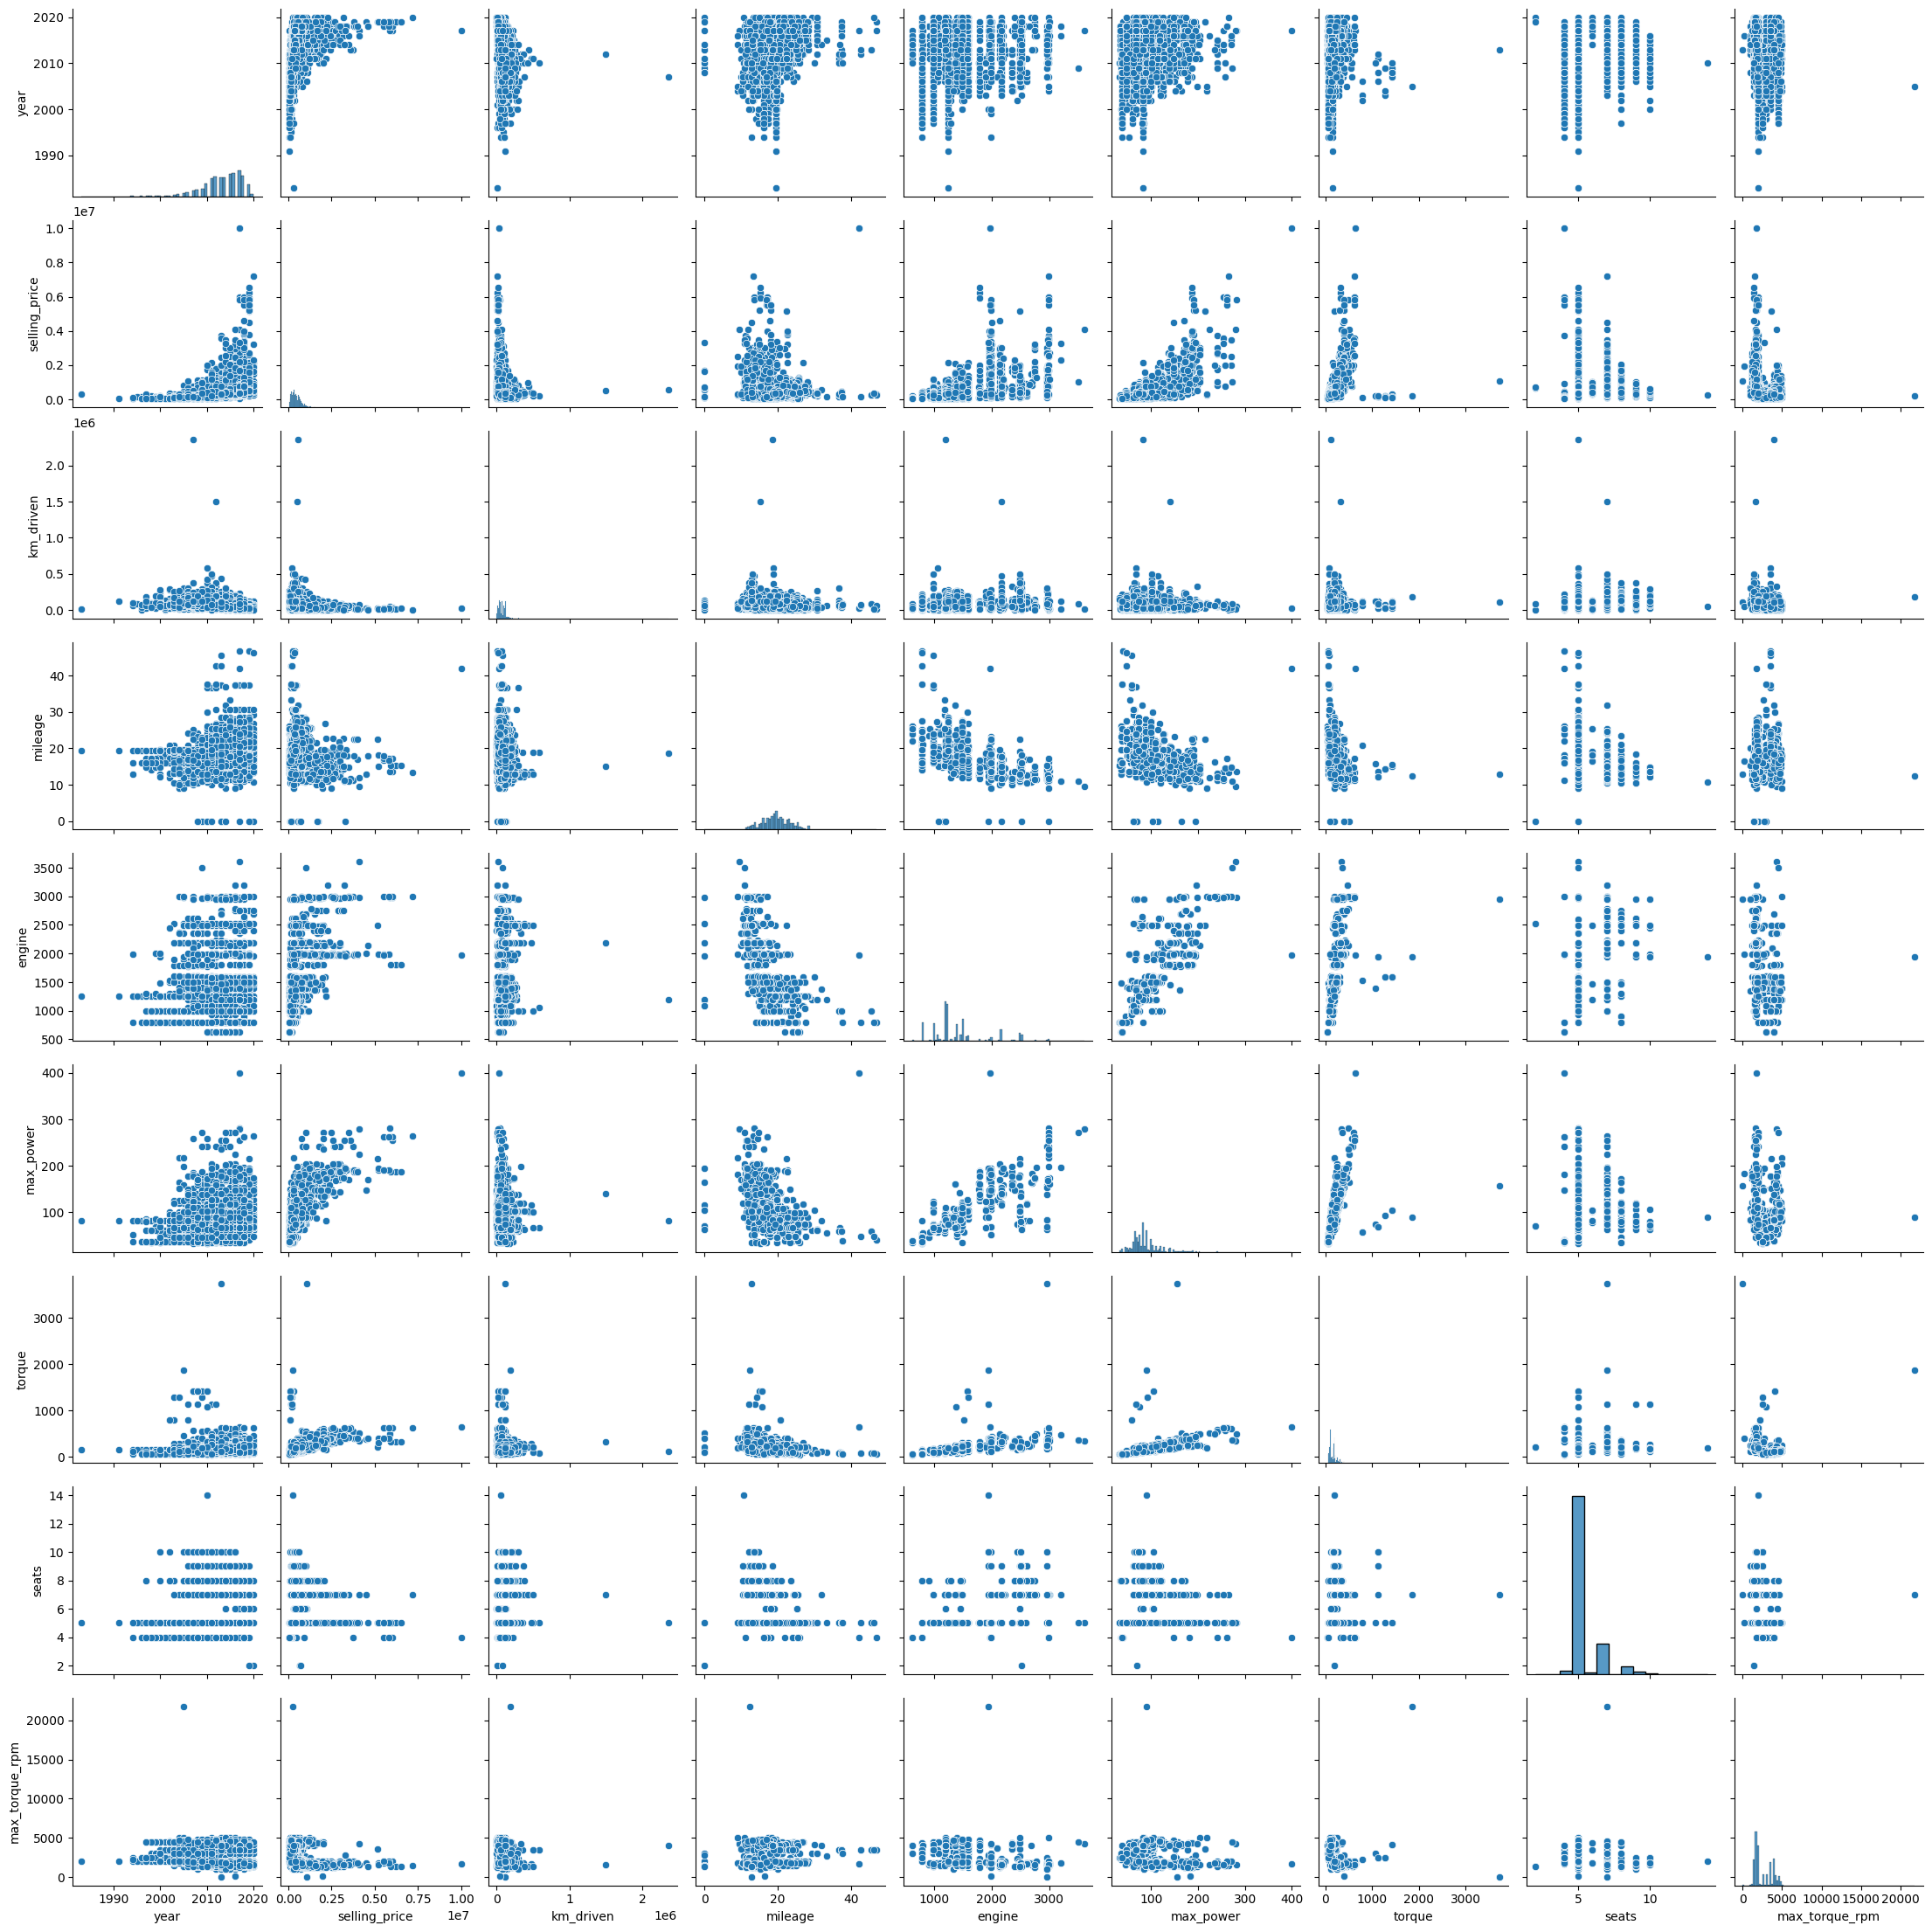

In [30]:
sns.pairplot(df_train)

Связи с целевой переменной мы, удачно, уже обнаруживали ранее, тут лишь подтвердим свои наблюдения. Поскольку распределения  зачастую не похожи на равномерные, это действительно может говорить о `связи переменных с таргетом`. `Наиболее выраженным` (в плане связи с таргетом) - я бы тут назвал `год`.

То же самое можно сказать и про корреляции. Они явно есть между некоторыми столбцами. Особенно в глаза бросается `max_power`-`engine`, вот уж неожиданная взаимосвязь :D (сарказм)

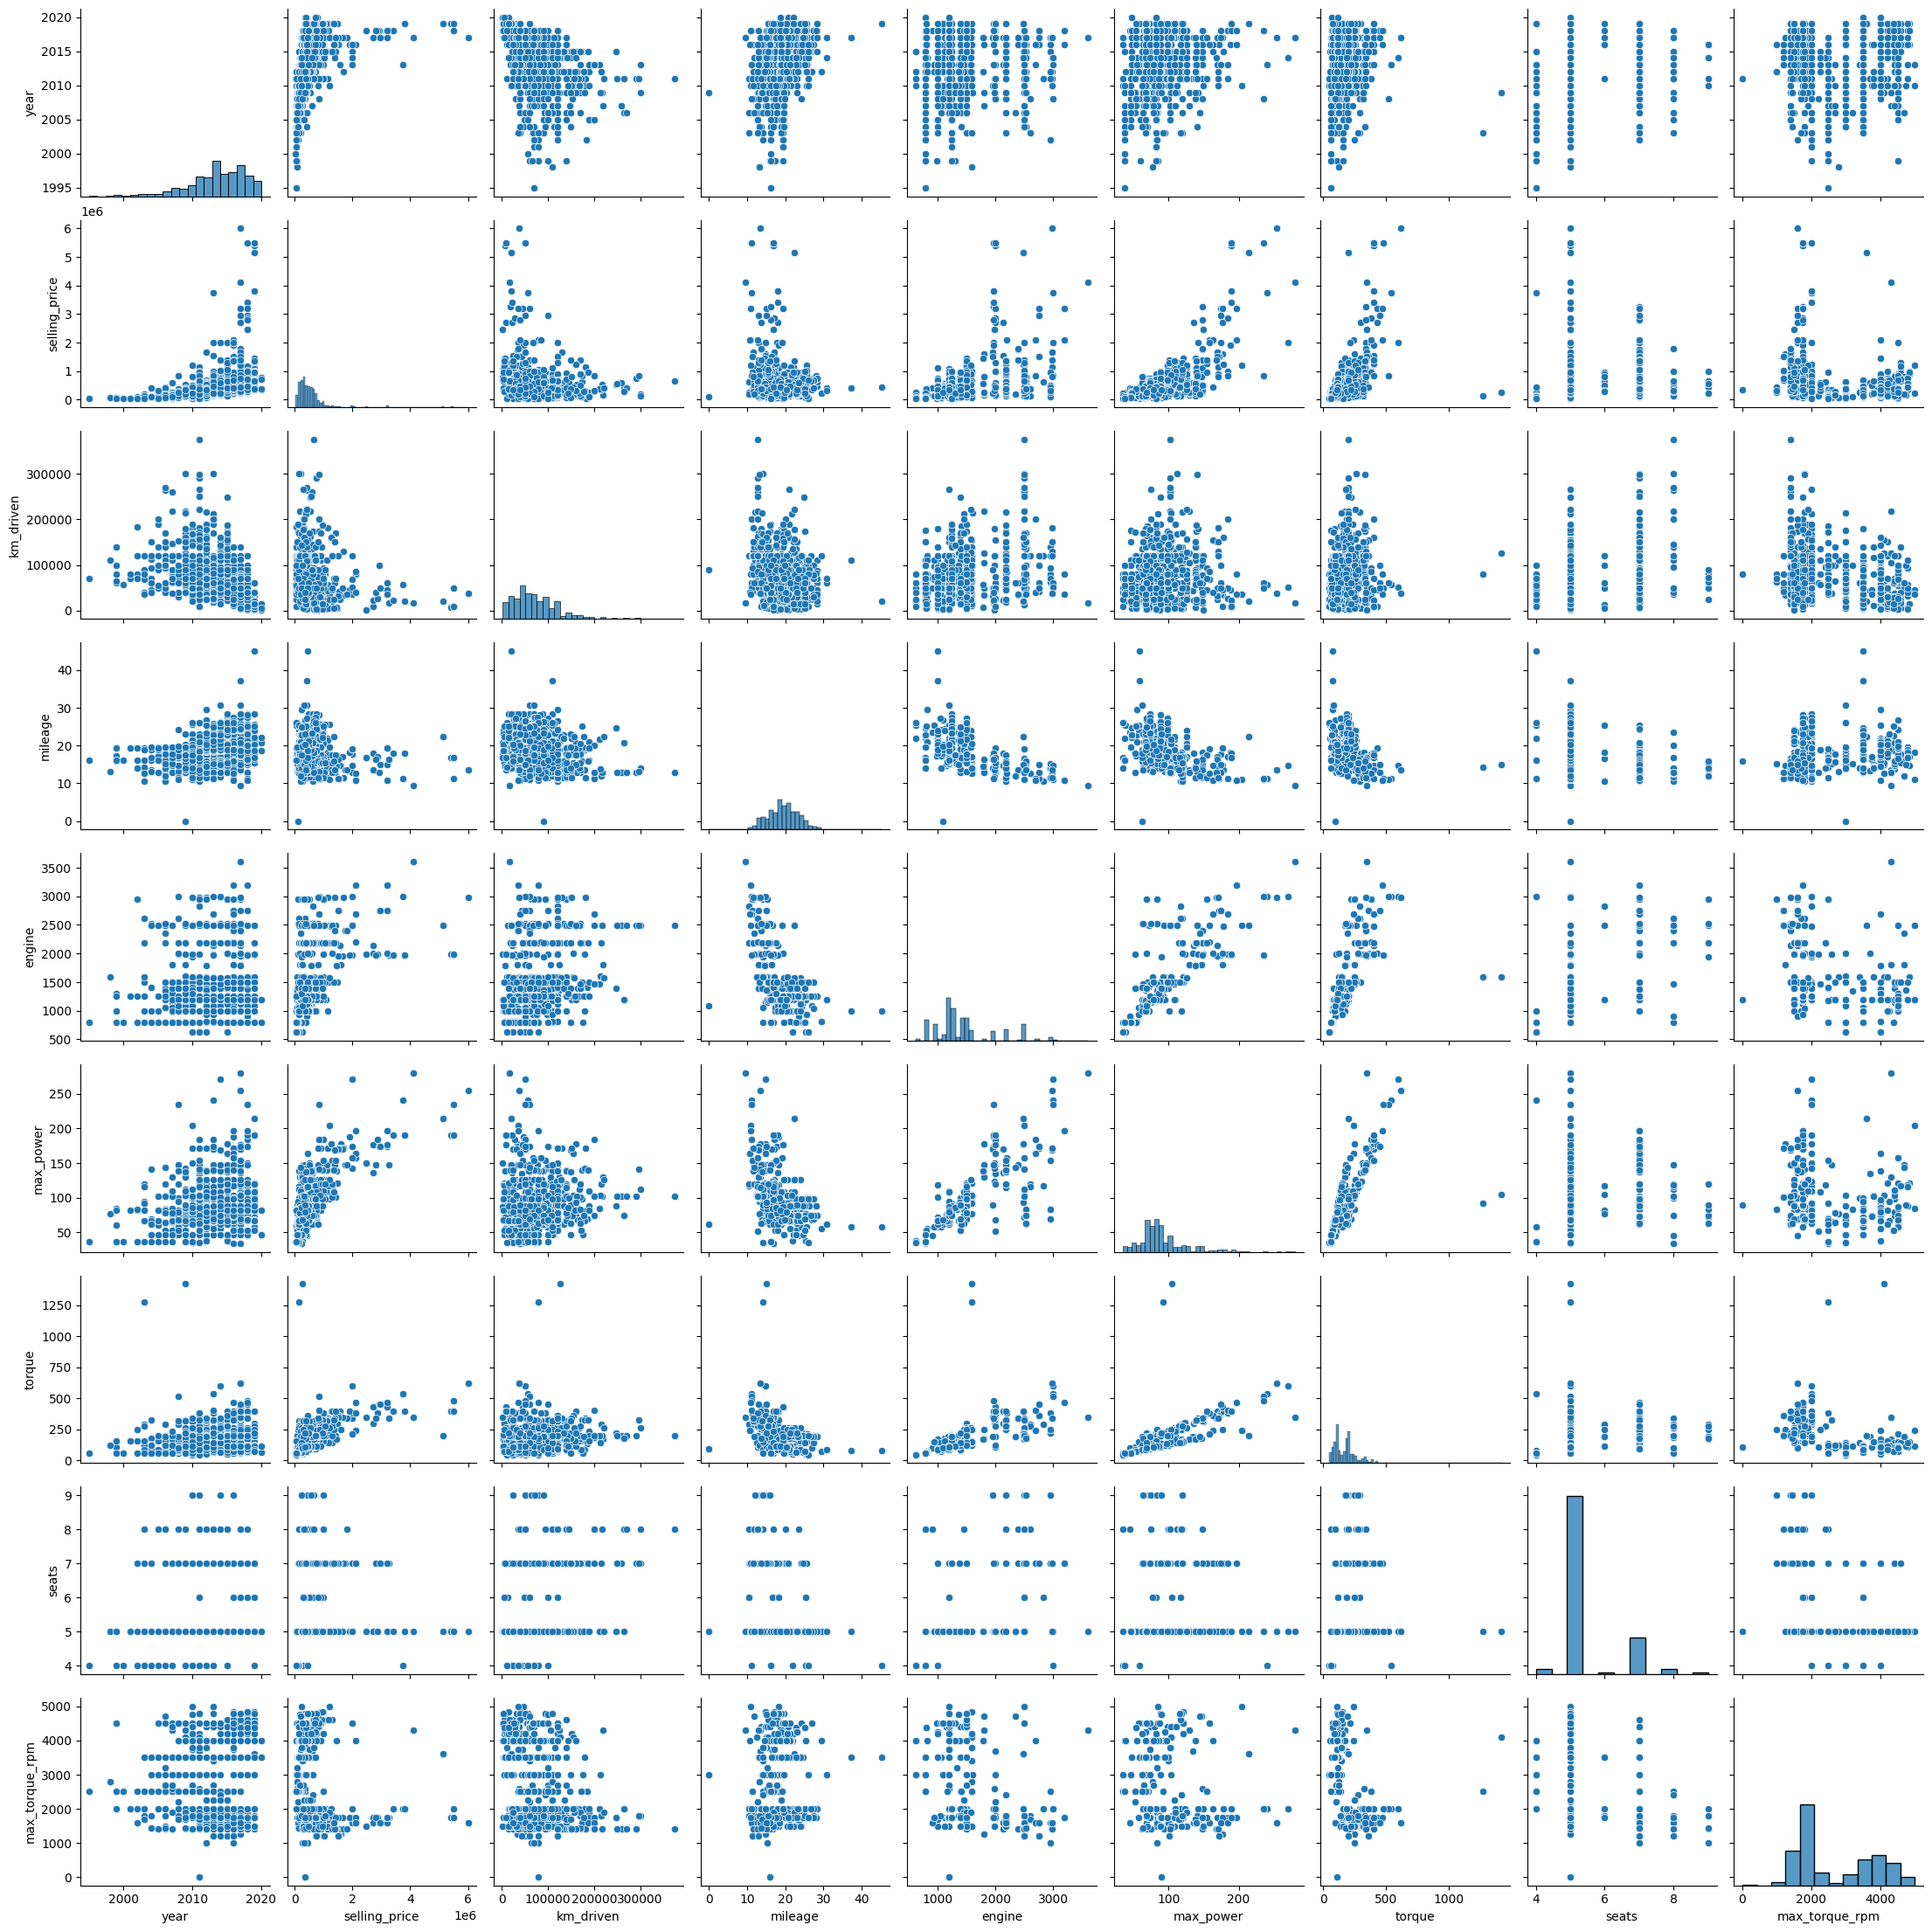

In [31]:
sns.pairplot(df_test)

Интересно. Я бы даже сказал, что в тесте некоторые взаимосвязи просматриваются чище. То есть, да, распределения где-то отличаются, но, главное, форма у них та же. Например, selling_price-torque.

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [32]:
numeric_cols = [col for col in df_train if df_train[col].dtype != "object"]
numeric_cols

['year',
 'selling_price',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'max_torque_rpm']

In [33]:
corrs = df_train[numeric_cols].corr()
corrs

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.427279,-0.368966,0.322860,0.002819,0.157138,0.048262,0.041178,0.008722
selling_price,0.427279,1.000000,-0.164828,-0.111323,0.447672,0.693742,0.433124,0.149953,-0.241327
km_driven,-0.368966,-0.164828,1.000000,-0.171749,0.229766,0.024539,0.106602,0.192328,-0.237342
mileage,0.322860,-0.111323,-0.171749,1.000000,-0.561690,-0.377439,-0.235107,-0.436971,0.009432
engine,0.002819,0.447672,0.229766,-0.561690,1.000000,0.681968,0.566066,0.652172,-0.475663
max_power,0.157138,0.693742,0.024539,-0.377439,0.681968,1.000000,0.617236,0.244017,-0.259087
torque,0.048262,0.433124,0.106602,-0.235107,0.566066,0.617236,1.000000,0.298097,-0.403166
seats,0.041178,0.149953,0.192328,-0.436971,0.652172,0.244017,0.298097,1.000000,-0.353292
max_torque_rpm,0.008722,-0.241327,-0.237342,0.009432,-0.475663,-0.259087,-0.403166,-0.353292,1.000000


<Axes: >

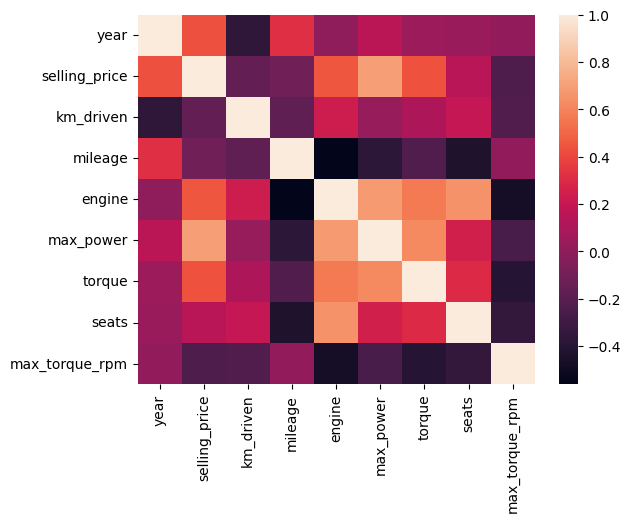

In [34]:
sns.heatmap(corrs)

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

`Your answer here`

Ответы:
1. `engine`-`year`. Корреляция между ними всего `0.002819`, что является абсолютным минимумом.
2. Наибольшая положительная корреляция между `selling_price` и `engine`: `0.693742`
3. И да, и нет. Между `year` и `km_driven` действительно `отрицательная корреляция`, то есть, они в обратной зависимости - чем меньше год, тем больше км. Но не забываем, что корреляция не означает причинность. Может на самом деле с новых машин просто скручивают активнее, поэтому появилась именно такая корреляция? :D
4. Как и было сказано в самом задании *(а также сказано буквально в соседней ячейке ниже)*, по умолчанию используется корреляция Пирсона =)

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


Для начала разберемся с корреляцией. Пусть будет Спирмена, потому что она в задании написана первой...  
Метод расчета взял по этой [ссылке](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

Формула:  
![формула](https://wikimedia.org/api/rest_v1/media/math/render/svg/82eae529334bfcd915eb0a11bd3f9297e4a6172d)

In [35]:
def spearmans_rank_correlation_coefficient(col1: pd.Series, col2: pd.Series) -> float:
    rank1 = col1.rank()
    rank2 = col2.rank()
    d2 = np.abs(rank1 - rank2) ** 2
    numerator = 6 * np.sum(d2)
    denumerator = len(col1) * ((len(col1) ** 2) - 1)
    return 1 - numerator / denumerator

In [36]:
col1 = pd.Series([86, 97, 99, 100, 101, 103, 106, 110, 112, 113])
col2 = pd.Series([2, 20, 28, 27, 50, 29, 7, 17, 6, 12])
spearmans_rank_correlation_coefficient(col1, col2)

-0.17575757575757578

In [37]:
pd.concat([col1, col2], axis=1).corr(method="spearman")

,0,1
0,1.000000,-0.175758
1,-0.175758,1.000000


Ну, вроде, работает, кроме тех случаев, когда не работает =)

Двигаемся дальше!)

А теперь построим phik.

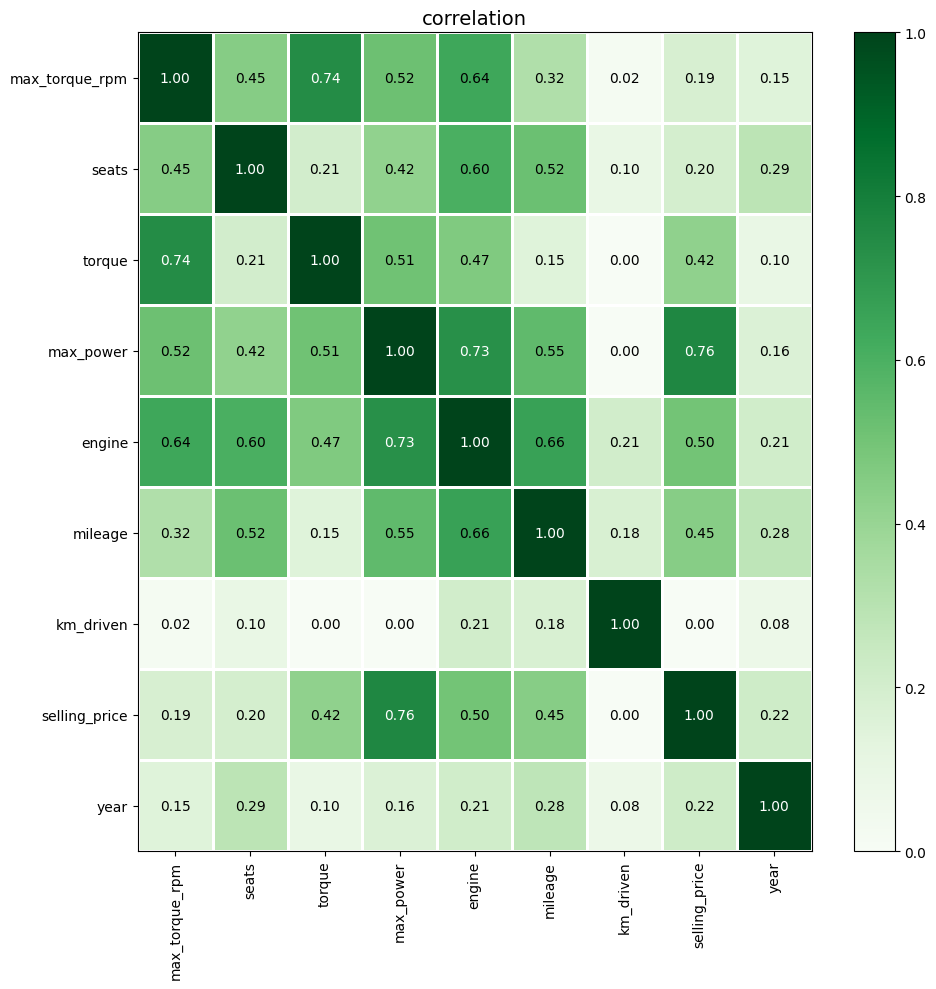

In [38]:
matrix = phik_matrix(df_train[numeric_cols], verbose=False)

plot_correlation_matrix(
    matrix.values,
    x_labels=matrix.columns,
    y_labels=matrix.index,
    figsize=(10, 10),
    color_map="Greens",
    vmin=0,
    vmax=1,
)

`Your answer here`

Ну, во-первых, phik матрица зачастую сразу получается значительно симпатичнее, не требуя настроек графика.

Во-вторых, стало видно больше корреляций с таргетом, что очень хорошо. Вероятно, действительно есть много нелинейных связей. Будем пытаться это учитывать при предсказании.

**`ВАЖНЫЙ МОМЕНТ!`**  
Почему-то в итоговой матрице буквально нулевая корреляция между пробегом и ценой продажи. Это и контринтуитивно, и противоречит предыдущим выводам.  
Первыми мыслями было, что я напутал подписи по x и y, в конечном итоге переделал так, что они берутся напрямую из рассчитанной матрицы и с ней совпадают.
Второй мыслью остается факт наличия ограничения шкалы не от -1 до 1, как обычно, а от 0 до 1. Мои указанные в отрисовке vmin и vmax на это не влияет, они влияют только на шкалу для раскраски, но не на сами значения. Возможно это означает полную обратную корреляцию. Ну или я просто балбес =)

<img src="https://i.pinimg.com/736x/31/51/40/315140a10ef7e4374a0a6dfc3dab6be7.jpg" alt="Барашб. Копаетб." width="400"/>

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

Мыслей именно по недоделанным графикам с точки зрения базового EDA сразу не возникает, но после недавних потрясений хочется ещё раз поближе взглянуть на взаимосвязь цены и пробега, а также посмотреть на сам таргет и возможные преобразования для будущего прогнозирования.
Также, с вашего позволения, буду тут использовать DEEPSEEK для оформления графиков, потому что красоты хочется, а вручную прописывать не хочется :D

Начнем с взаимосвязи.

#### Взаимосвязь пробега и цены продажи

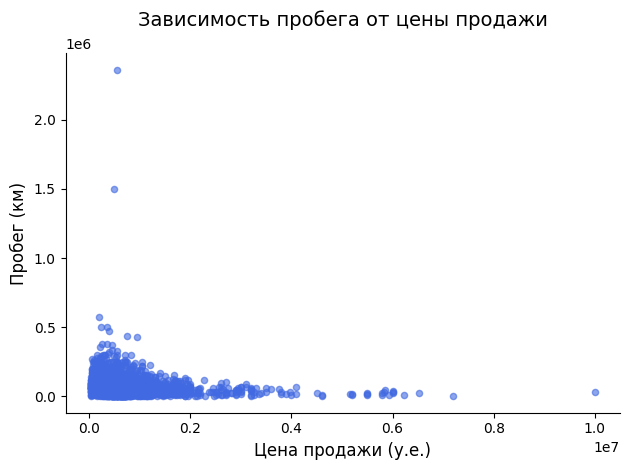

In [39]:
# Создаем график
plt.scatter(
    df_train["selling_price"],
    df_train["km_driven"],
    alpha=0.6,  # Полупрозрачные точки для лучшего восприятия плотности
    s=20,  # Размер точек
    color="royalblue",
)

# Добавляем заголовок и подписи осей
plt.title("Зависимость пробега от цены продажи", fontsize=14, pad=20)
plt.xlabel("Цена продажи (у.е.)", fontsize=12)
plt.ylabel("Пробег (км)", fontsize=12)

# Убираем лишние рамки (эстетика seaborn)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Показать график
plt.tight_layout()
plt.show()

Явная беда с выбросами. Сейчас просто отрисуем без них, а потом отдельно проверим все столбцы на наличие больших выбросов.

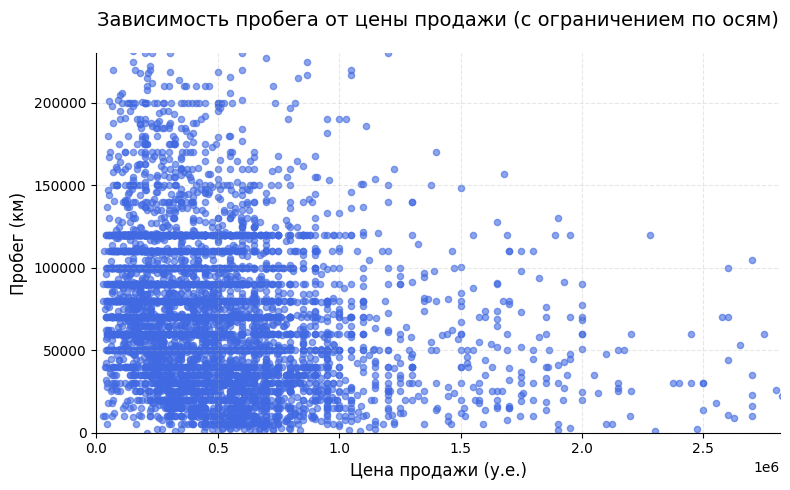

In [40]:
# Создаем фигуру и оси явно - это помогает избежать путаницы
fig, ax = plt.subplots(figsize=(8, 5))

# Строим scatter plot на осях ax
scatter = ax.scatter(
    df_train["selling_price"],
    df_train["km_driven"],
    alpha=0.6,  # Полупрозрачные точки для лучшего восприятия плотности
    s=20,  # Размер точек
    color="royalblue",
)

# Устанавливаем лимиты для осей через объект ax
ax.set_xlim(0, df_train["selling_price"].quantile(0.99))
ax.set_ylim(0, df_train["km_driven"].quantile(0.99))

# Добавляем заголовок и подписи осей через ax
ax.set_title(
    "Зависимость пробега от цены продажи (с ограничением по осям)", fontsize=14, pad=20
)
ax.set_xlabel("Цена продажи (у.е.)", fontsize=12)
ax.set_ylabel("Пробег (км)", fontsize=12)

# Убираем лишние рамки через объект ax
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Добавляем сетку для лучшей читаемости
ax.grid(True, linestyle="--", alpha=0.3)

# Показать график
plt.tight_layout()
plt.show()

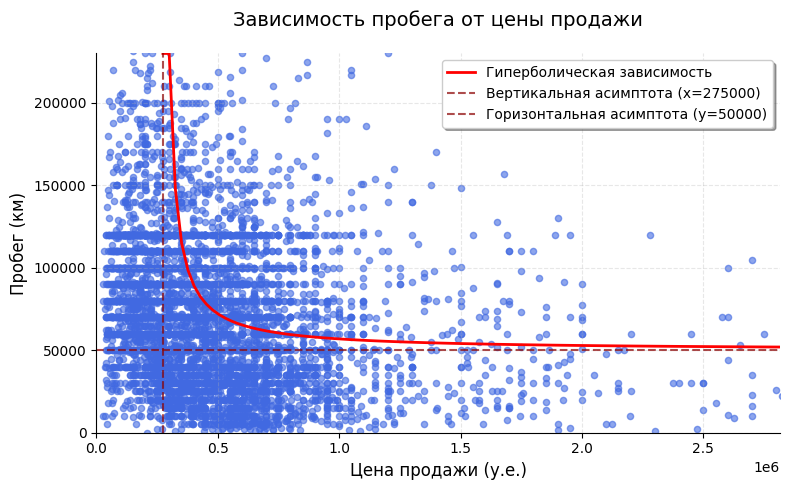

In [41]:
# Создаем фигуру и оси явно - это помогает избежать путаницы
fig, ax = plt.subplots(figsize=(8, 5))

# Строим scatter plot на осях ax
scatter = ax.scatter(
    df_train["selling_price"],
    df_train["km_driven"],
    alpha=0.6,  # Полупрозрачные точки для лучшего восприятия плотности
    s=20,  # Размер точек
    color="royalblue",
)

# Устанавливаем лимиты для осей через объект ax
ax.set_xlim(0, df_train["selling_price"].quantile(0.99))
ax.set_ylim(0, df_train["km_driven"].quantile(0.99))

# ДОБАВЛЯЕМ ЛИНЕЙНЫЙ ГРАФИК И АСИМПТОТЫ
x_vertical = 275000  # Вертикальная асимптота
y_horizontal = 50000  # Горизонтальная асимптота

# Создаем данные для кривой гиперболического вида 1/x в новой системе координат
x_new = np.linspace(1, df_train["selling_price"].quantile(0.99) - x_vertical, 100)
# Функция вида y_new = A / x_new (гипербола)
A = 5000000000  # Параметр для настройки крутизны
y_new = A / x_new

# Переводим обратно в исходные координаты
x_fit = x_vertical + x_new
y_fit = y_horizontal + y_new

# Ограничиваем значения по Y (чтобы не выходило за пределы графика)
y_fit = np.clip(y_fit, y_horizontal, df_train["km_driven"].quantile(0.99))

# Рисуем гиперболическую зависимость
ax.plot(
    x_fit,
    y_fit,
    color="red",
    linewidth=2,
    linestyle="-",
    label="Гиперболическая зависимость",
)

# Добавляем вертикальную линию (асимптоту)
ax.axvline(
    x=x_vertical,
    color="darkred",
    linestyle="--",
    alpha=0.7,
    linewidth=1.5,
    label=f"Вертикальная асимптота (x={x_vertical:.0f})",
)

# Добавляем горизонтальную линию (асимптоту)
ax.axhline(
    y=y_horizontal,
    color="darkred",
    linestyle="--",
    alpha=0.7,
    linewidth=1.5,
    label=f"Горизонтальная асимптота (y={y_horizontal:.0f})",
)

# Добавляем заголовок и подписи осей через ax
ax.set_title("Зависимость пробега от цены продажи", fontsize=14, pad=20)
ax.set_xlabel("Цена продажи (у.е.)", fontsize=12)
ax.set_ylabel("Пробег (км)", fontsize=12)

# Убираем лишние рамки через объект ax
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Добавляем сетку для лучшей читаемости
ax.grid(True, linestyle="--", alpha=0.3)

# Добавляем легенду
ax.legend(loc="upper right", frameon=True, fancybox=True, shadow=True)

# Показать график
plt.tight_layout()
plt.show()

Попробовал нарисовать график, описывающий зависимость переменных (лучше бы не пробовал, дипсик в упор не хотел понимать, что я от него хочу).

В общем, некоторая зависимость есть, но она выражена достаточно слабо. Соответственно, больших значений что прямой, что обратной корреляции тут ждать и не следовало. В общем, наши предыдущие выводы остаются достаточно достоверными, просто при подсчете через phik эта слабая зависимость могла совсем потеряться из=за другого метода расчета.

#### Близкий взгляд на selling_price.

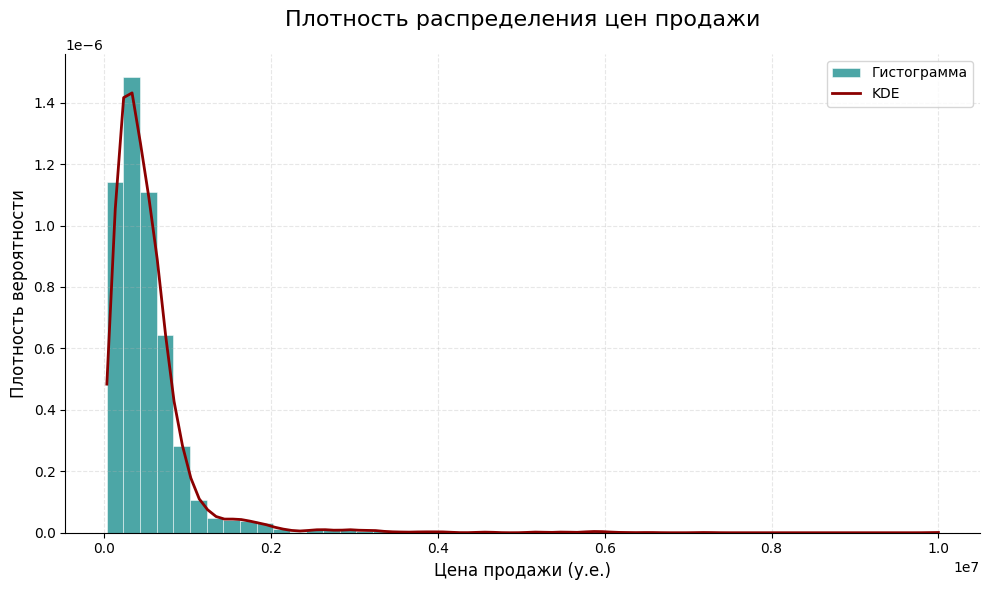

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))

# Гистограмма с нормализованной плотностью
n, bins, patches = ax.hist(
    df_train["selling_price"],
    bins=50,
    density=True,
    alpha=0.7,
    color="teal",
    edgecolor="white",
    linewidth=0.5,
    label="Гистограмма",
)

# Добавляем KDE (Kernel Density Estimation)
kde = stats.gaussian_kde(df_train["selling_price"])
x_kde = np.linspace(
    df_train["selling_price"].min(), df_train["selling_price"].max(), 100
)
ax.plot(x_kde, kde(x_kde), color="darkred", linewidth=2, label="KDE")

# Настройка оформления
ax.set_title("Плотность распределения цен продажи", fontsize=16, pad=20)
ax.set_xlabel("Цена продажи (у.е.)", fontsize=12)
ax.set_ylabel("Плотность вероятности", fontsize=12)

# Убираем лишние рамки
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Сетка
ax.grid(True, linestyle="--", alpha=0.3)

# Легенда
ax.legend(loc="upper right", frameon=True)

plt.tight_layout()
plt.show()

Угадайте, что? Правильно, выбросы!)

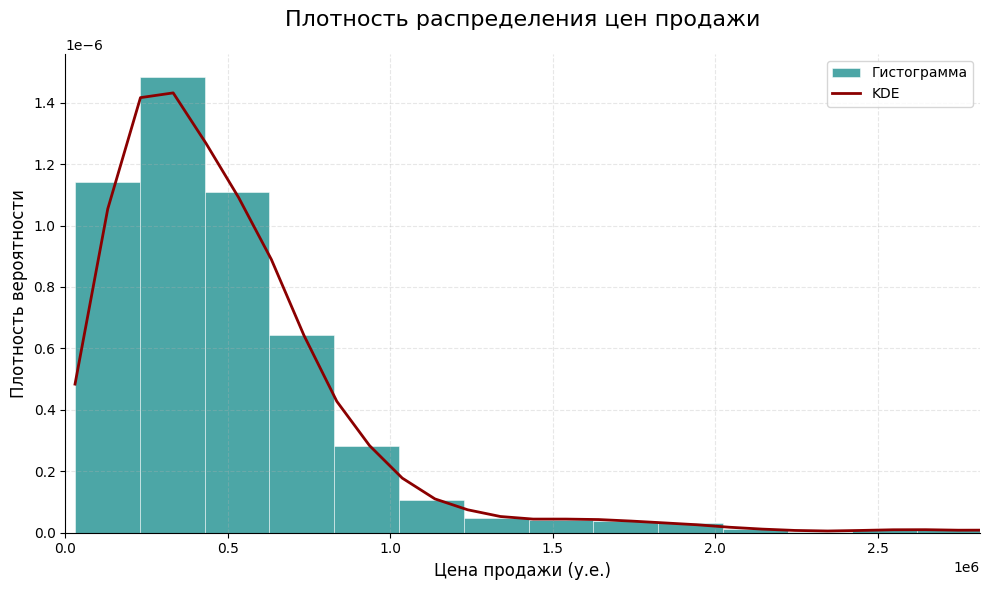

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

# Гистограмма с нормализованной плотностью
n, bins, patches = ax.hist(
    df_train["selling_price"],
    bins=50,
    density=True,
    alpha=0.7,
    color="teal",
    edgecolor="white",
    linewidth=0.5,
    label="Гистограмма",
)

# Добавляем KDE (Kernel Density Estimation)
kde = stats.gaussian_kde(df_train["selling_price"])
x_kde = np.linspace(
    df_train["selling_price"].min(), df_train["selling_price"].max(), 100
)
ax.plot(x_kde, kde(x_kde), color="darkred", linewidth=2, label="KDE")
ax.set_xlim(0, df_train["selling_price"].quantile(0.99))

# Настройка оформления
ax.set_title("Плотность распределения цен продажи", fontsize=16, pad=20)
ax.set_xlabel("Цена продажи (у.е.)", fontsize=12)
ax.set_ylabel("Плотность вероятности", fontsize=12)

# Убираем лишние рамки
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Сетка
ax.grid(True, linestyle="--", alpha=0.3)

# Легенда
ax.legend(loc="upper right", frameon=True)

plt.tight_layout()
plt.show()

Уже лучше, но попробуем логарифмировать и посмотреть, что получится

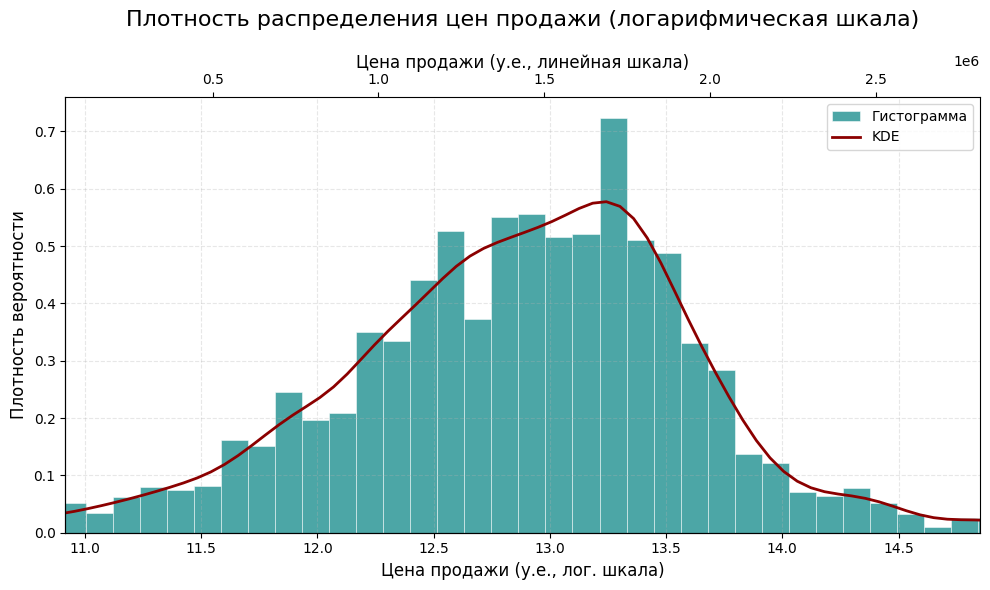

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

data = np.log(df_train["selling_price"])

# Гистограмма с нормализованной плотностью
n, bins, patches = ax.hist(
    data,
    bins=50,
    density=True,
    alpha=0.7,
    color="teal",
    edgecolor="white",
    linewidth=0.5,
    label="Гистограмма",
)

# Добавляем KDE
kde = stats.gaussian_kde(data)
x_kde = np.linspace(data.min(), data.max(), 100)
ax.plot(x_kde, kde(x_kde), color="darkred", linewidth=2, label="KDE")
ax.set_xlim(data.quantile(0.01), data.quantile(0.99))

# Настройка оформления с обратным преобразованием подписей
ax.set_title(
    "Плотность распределения цен продажи (логарифмическая шкала)", fontsize=16, pad=20
)
ax.set_xlabel("Цена продажи (у.е., лог. шкала)", fontsize=12)
ax.set_ylabel("Плотность вероятности", fontsize=12)

# Можно добавить вторую ось с оригинальными ценами
ax2 = ax.twiny()
ax2.set_xlim(np.exp(data.quantile(0.01)), np.exp(data.quantile(0.99)))
ax2.set_xlabel("Цена продажи (у.е., линейная шкала)", fontsize=12)

# Убираем лишние рамки
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Сетка
ax.grid(True, linestyle="--", alpha=0.3)

# Легенда
ax.legend(loc="upper right", frameon=True)

plt.tight_layout()
plt.show()

Так стало значительно приятнее, но появилась проблема с тем, что теперь и начало подрезать приходится:
```python
ax.set_xlim(data.quantile(0.01), data.quantile(0.99))
```

В общем, можно будет попробовать применить это преобразование, но делать это надо будет очень осторожно.

In [45]:
df_train.sort_values("selling_price", ascending=True).head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
4152,Maruti 800 AC,1997,29999,80000,Petrol,Individual,Manual,Third Owner,16.1,796,37.00,59.0,4,2500.0
4914,Hyundai Santro GLS I - Euro I,2000,30000,90000,Petrol,Individual,Manual,Third Owner,19.4,1248,81.86,160.0,5,2000.0
1668,Maruti Zen LXI,2001,30000,10000,Petrol,Individual,Manual,First Owner,17.3,993,60.00,78.0,5,4500.0
1481,Maruti 800 Std,2004,31504,110000,Petrol,Individual,Manual,Third Owner,16.1,796,37.00,59.0,4,2500.0
5761,Maruti 800 AC,1998,35000,40000,Petrol,Individual,Manual,Second Owner,16.1,796,37.00,59.0,4,2500.0


Что-ж, это явно не похоже на выбросы, так что просто выкинуть будет плохой идеей.

#### Наконец, посмотрим на общую ситуацию по выбросам

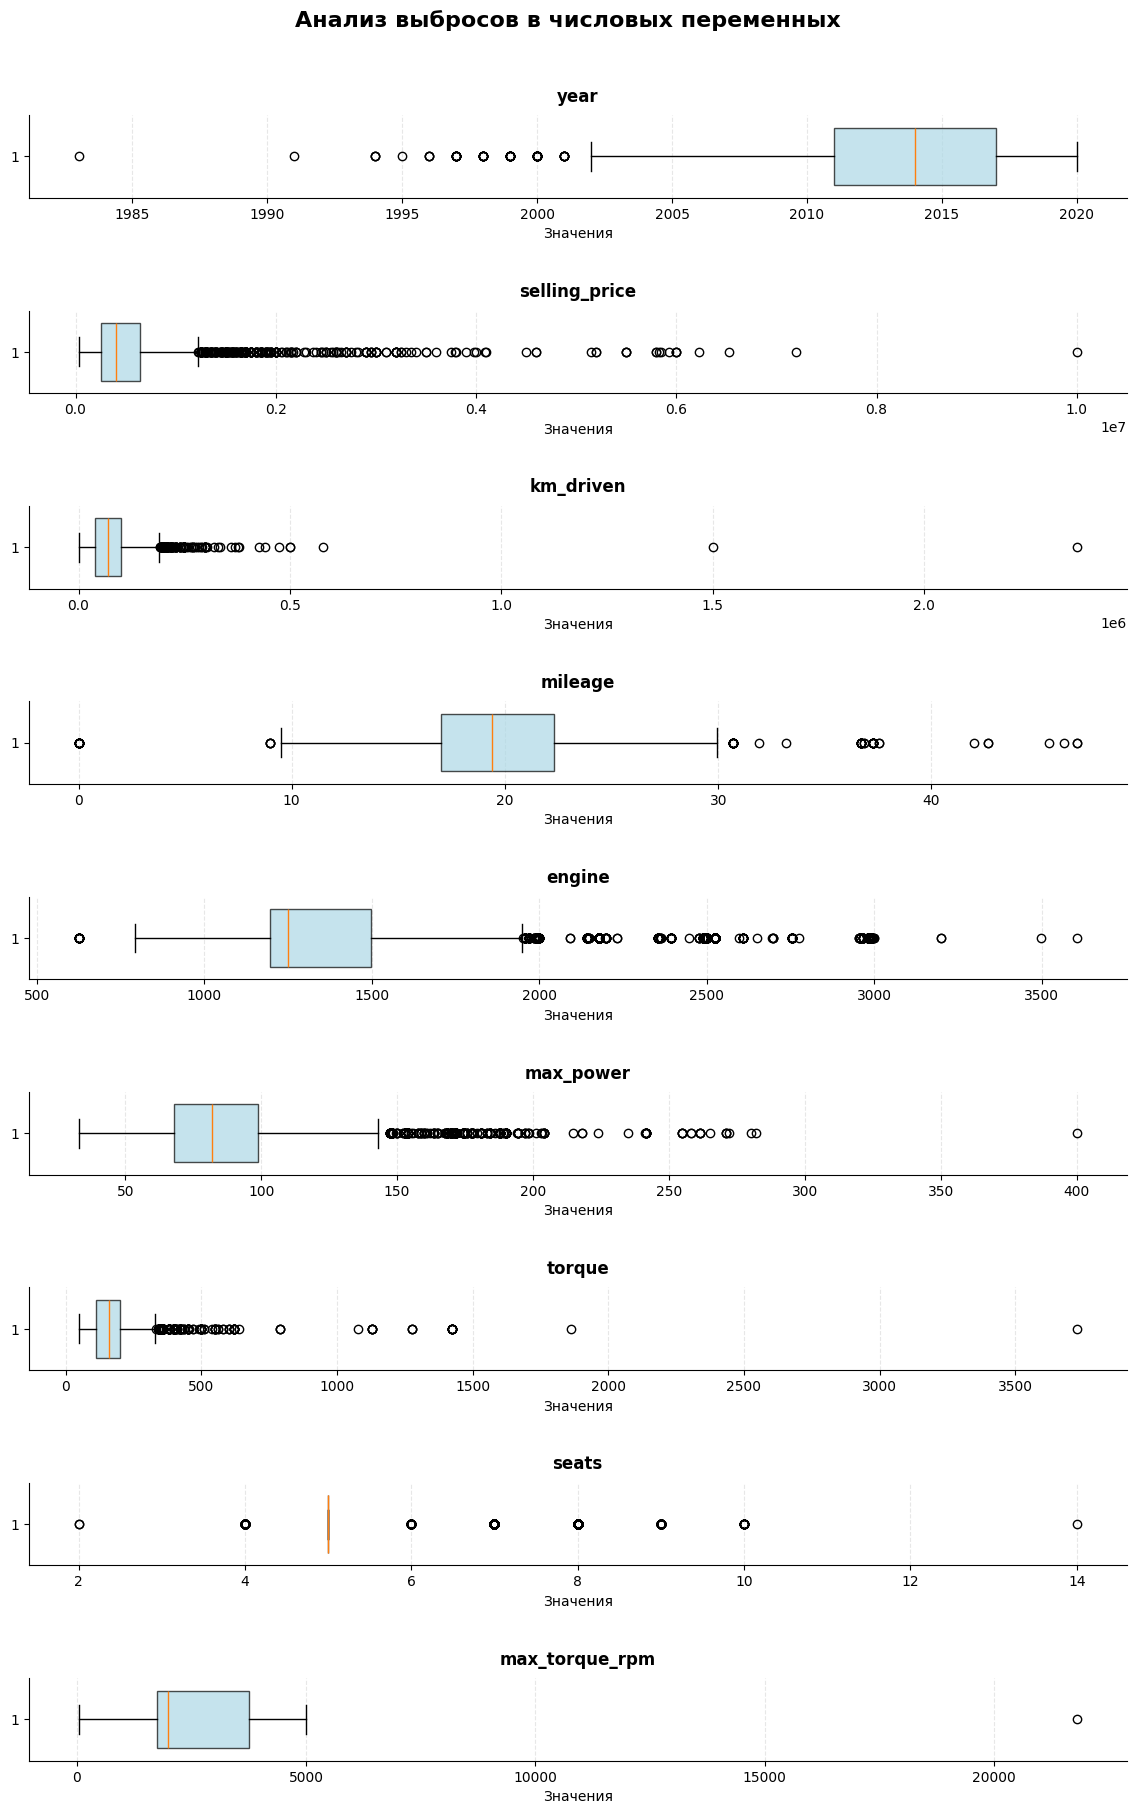

In [46]:
# Определяем количество строк и столбцов для subplot
n_cols = 1  # Количество графиков в строке
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # Округление вверх

# Создаем сетку графиков
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
axes = axes.flatten()  # Преобразуем в плоский массив для удобства

# Проходим по всем числовым столбцам
for i, col in enumerate(numeric_cols):
    if i < len(axes):  # Защита от выхода за границы
        # Строим горизонтальный ящик с усами
        boxplot = axes[i].boxplot(
            df_train[col],
            vert=False,  # Горизонтальный
            patch_artist=True,  # Заливка
            widths=0.7,
        )  # Ширина ящиков

        # Настройка цвета
        boxplot["boxes"][0].set_facecolor("lightblue")
        boxplot["boxes"][0].set_alpha(0.7)

        # Настройка оформления
        axes[i].set_title(f"{col}", fontsize=12, fontweight="bold", pad=10)
        axes[i].set_xlabel("Значения", fontsize=10)
        axes[i].grid(True, axis="x", linestyle="--", alpha=0.3)

        # Убираем лишние рамки
        axes[i].spines["top"].set_visible(False)
        axes[i].spines["right"].set_visible(False)

# Удаляем лишние subplot'ы
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.suptitle(
    "Анализ выбросов в числовых переменных", fontsize=16, fontweight="bold", y=1.02
)
plt.show()

Наиболее ярко выраженные видны в столбцах: 
* year
* selling_price
* km_driven
* mileage (0 - нулевой расход? Практичненько, но есть у меня сомнения...)
* max_power
* torque
* max_torque_rpm

И есть подозрения, что большая часть этих выбросов может быть в одном наблюдении (поскольку достаточно много полей отклоняются в одну сторону). Проверим это

In [47]:
df_train[df_train["selling_price"] == df_train["selling_price"].max()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
151,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0,1969,400.0,640.0,4,1740.0


In [48]:
df_train[df_train["name"].apply(lambda x: True if "XC90" in x else False)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
151,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0,1969,400.0,640.0,4,1740.0


Тут мы поймали одновременный выброс в `цене` и в `max_power`. Но такая машина всего одна, так что сравнить не с чем. Ну и ладно. Посмотрим на других представителей выбросов, раз они не все в одном.

In [49]:
df_train[df_train["km_driven"] == df_train["km_driven"].max()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
2680,Hyundai i20 Asta 1.2,2007,550000,2360457,Petrol,Individual,Manual,Second Owner,18.6,1197,81.83,114.7,5,4000.0


Ну, что ж, гипотеза с тем, что большинство выбросов в одном наблюдении явно не подтвердилась. Есть по нескольку машин, содержащих выбросы, но посмотрев на них поближе, я, честно, не уверен, насколько корректно будет их удалять.

Да, для линейной модели выбросы - большущая беда, но тут они все же логически корректны. Для работы на проде и имея больше данных, вероятно, стоило бы просто делать разные модели для разных, например, ценовых или мощностных категорий машин, но тут мы используем одну модель, поэтому пусть просто остаются до лучших времен. Вспомним про это при явной необходимости позже.

#### Вывод по дополнительной визуализации

1. Между переменными `selling_price` и `km_driven` видна слабая взаимосвязь. По результатам эксперемента подтверждены выводы из начала работы - о слабой корреляции между ними, но также найдено предположение о том, почему phik корреляция взаимосвязь не показывает совсем.

2. При логарифмировании `selling_price` распределение выравнивается ближе к колоколу нормального распределения, но все ещё таковым полноценно не является. Можно попробовать применить логарифмирование для улучшения предсказательной способности линейной модели, но делать это необходимо осторожно.

3. В датасете (тренировочном наборе) `действительно есть достаточно немало выбросов`, но зачастую оказывается, что `выбросы не случайны`, а `являются` действительно `особенностями конкретных наблюдений`, поэтому на данный момент принято решение о том, чтобы `оставить их в датасете`.

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Сделайте на тренировочный и тестовый наборы. Она уже даны, достаточно просто отделить целевой признак. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных. Используйте уже имеющиеся данные train и test. Если считаете уместным применить какую-то более хитрую технику разбиения — примените, но опишите, зачем.

In [50]:
y_train = df_train["selling_price"]
X_train = df_train[numeric_cols].drop(["selling_price"], axis=1)

In [51]:
# опишите выбранные вещественные признаки
X_train.describe()  # честно, просто не понятно, что надо описать, если мы всю первую часть работы только этим и занимались

,year,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5840.000000,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,7.395224e+04,19.547135,1429.448973,87.948422,175.930478,5.426712,2658.846182
std,4.095622,6.007114e+04,4.228290,485.662834,31.577884,116.757608,0.982344,1116.793535
min,1983.000000,1.000000e+00,0.000000,624.000000,32.800000,47.071920,2.000000,38.700000
25%,2011.000000,3.900000e+04,17.000000,1197.000000,68.000000,111.800000,5.000000,1750.000000
50%,2014.000000,7.000000e+04,19.400000,1248.000000,81.860000,160.000000,5.000000,2000.000000
75%,2017.000000,1.000000e+05,22.320000,1498.000000,99.000000,200.055660,5.000000,3750.000000
max,2020.000000,2.360457e+06,46.816000,3604.000000,400.000000,3726.527000,14.000000,21800.000000


In [52]:
y_test = df_test["selling_price"]
X_test = df_test[numeric_cols].drop(["selling_price"], axis=1)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [53]:
# your code here
lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

print(f"R2: {r2_score(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")

R2: 0.5976303092498518
MSE: 231293588166.59518


Метрики можно описать одним словом - **беда**. 

R2 получился достаточно низким, а MSE вообще в сторону космоса улетел =)

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

<img src="https://i2.wp.com/miro.medium.com/0*EmJ1gkI6B0fGE4eE" alt="R2" width="400"/>

In [54]:
def r2(y_true: pd.Series, y_pred: pd.Series) -> float:
    numerator = np.sum((y_true - y_pred) ** 2)
    denumerator = np.sum((y_true - y_true.mean()) ** 2)
    return 1 - numerator / denumerator

In [55]:
print(f"Библиотечный R2: {r2_score(y_test, pred)}")
print(f"Самописный R2: {r2(y_test, pred)}")

Библиотечный R2: 0.5976303092498518
Самописный R2: 0.5976303092498518


`Your answer here`

R2 (он же коэффициент детерминации) отражает, если можно так выразиться, долю объясненной дисперсии.

Формула состоит из следующих элементов:
1. Числитель. Это MSE - разница фактических и предсказанных значений, возведенная в квадрат. Нужна для оценки наших предсказаний.
2. Знаменатель. MSE, посчитанное от константного предсказания - среднего фактических значений.

Сравнивая их между собой (операция деления) мы получаем результат, показывающий насколько наши предсказания лучше константных. При этом 0 - идеальные предсказания, а чем выше число - тем наоборот результат хуже.

И вычитая это значение из единицы мы и получаем привычный вид оценивания, где 1 - хорошо, а 0 и меньше - плохо.

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/16a082d105dfbb4339e40cf7898950ce748743e8" alt="adjusted R2" width="400"/>

In [56]:
def adjusted_r2(y_true: pd.Series, y_pred: pd.Series, num_variables: int) -> float:
    numerator = (1 - r2(y_true, y_pred)) * (len(y_true) - 1)
    denumerator = len(y_true) - num_variables - 1
    return 1 - numerator / denumerator

In [57]:
print(f"Самописный adjusted R2: {adjusted_r2(y_test, pred, len(X_train.columns))}")

Самописный adjusted R2: 0.5943821180026256


`Your answer here`

Adjusted R2 может применяться, чтобы учитывать количество фичей (независимых переменных) при оценке модели. Может быть полезно при отборе фичей, чтобы находить баланс между сложностью модели и её предиктивной способностью.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [58]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [59]:
lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

pred_scaled = lr_scaled.predict(X_test_scaled)

print(f"R2 со скалированием: {r2_score(y_test, pred_scaled)}")
print(f"MSE со скалированием: {mean_squared_error(y_test, pred_scaled)}")
print("-----------------------")
print(f"R2 до скалирования: {r2_score(y_test, pred)}")
print(f"MSE до скалирования: {mean_squared_error(y_test, pred)}")

R2 со скалированием: 0.5976303092498525
MSE со скалированием: 231293588166.5948
-----------------------
R2 до скалирования: 0.5976303092498518
MSE до скалирования: 231293588166.59518


Уже пора паниковать, что я что-то где-то сделал не так?)0)

### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [60]:
lr_scaled.coef_

array([159986.63309913, -49841.19822152,   2861.88886841,  21180.46829981,
       324192.09866682,   3810.87034367, -29796.99474938, -57376.96375085])

<BarContainer object of 8 artists>

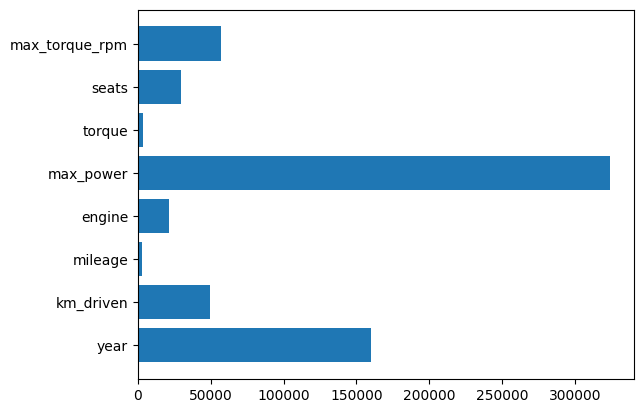

In [61]:
plt.barh(X_train.columns, np.abs(lr_scaled.coef_))

Воспользуюсь DEEPSEEK для оформления графика

In [62]:
def plot_coefs(linear_model, model_name: str, df=None, top: int = None) -> None:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Получаем названия фичей и коэффициенты
    feature_names = df.columns if df is not None else X_train.columns
    coef_abs = np.abs(linear_model.coef_)

    # Сортируем по важности
    sorted_idx = np.argsort(coef_abs)

    # Обрезаем до top фичей если нужно
    if top is not None and top < len(coef_abs):
        sorted_idx = sorted_idx[-top:]
        coef_abs = coef_abs[sorted_idx]
        feature_names = feature_names[sorted_idx]
    else:
        feature_names = feature_names[sorted_idx]
        coef_abs = coef_abs[sorted_idx]

    # Барплот
    bars = ax.barh(feature_names, coef_abs, color="#2E86AB", alpha=0.9, height=0.6)

    # Только для значимых коэффициентов добавляем подписи
    for bar, value in zip(bars, coef_abs):
        if value > 0.1:  # Порог для подписей
            ax.text(
                bar.get_width() + 0.005,
                bar.get_y() + bar.get_height() / 2,
                f"{value:.2f}",
                ha="left",
                va="center",
                fontsize=8,
            )

    # Оформление в минималистичном стиле
    ax.set_xlabel("Величина коэффициента", fontsize=10)

    # Добавляем информацию о top в заголовок если используется
    title = f"Важность признаков {model_name}"
    if top is not None:
        title += f" (топ {top})"
    ax.set_title(title, fontsize=14, pad=15)

    # Тонкая сетка
    ax.grid(True, axis="x", linestyle=":", alpha=0.2)
    ax.set_axisbelow(True)

    # Только нижняя рамка
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.tight_layout()
    plt.show()

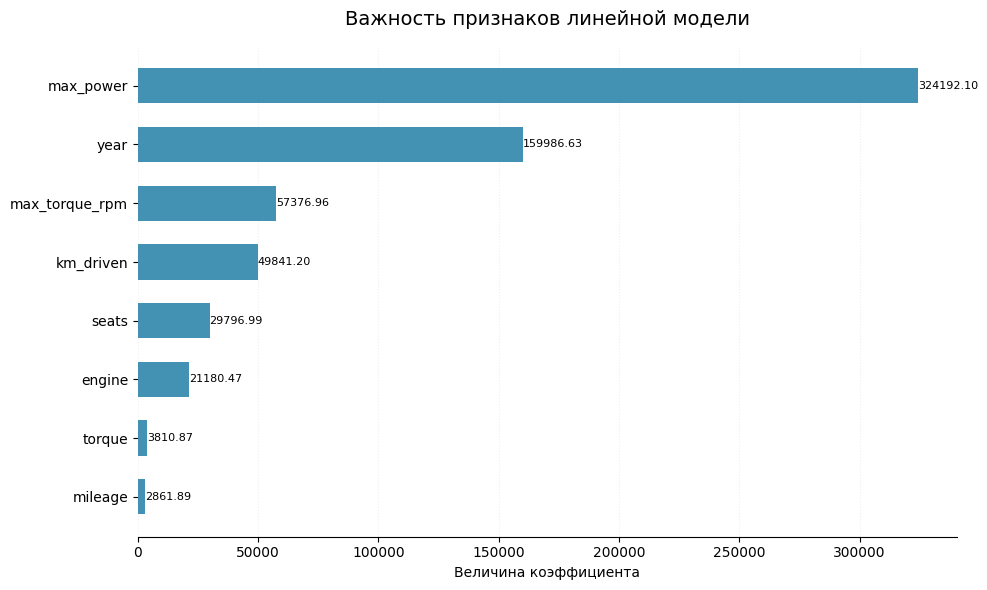

In [63]:
plot_coefs(lr_scaled, "линейной модели")

Наиболее информативным оказался признак `max_power`. Результаты согласованы с ожиданиями - ранее мы видели, что это самый скорелированный признак с таргетом.

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [64]:
lasso = Lasso(random_state=42)
lasso.fit(X_train_scaled, y_train)

lasso_pred = lasso.predict(X_test_scaled)

print(f"R2 для lasso: {r2_score(y_test, lasso_pred)}")
print(f"MSE для lasso: {mean_squared_error(y_test, lasso_pred)}")
print("-----------------------")
print(f"R2 начальный: {r2_score(y_test, pred)}")
print(f"MSE начальный: {mean_squared_error(y_test, pred)}")

R2 для lasso: 0.5976290927832464
MSE для lasso: 231294287426.337
-----------------------
R2 начальный: 0.5976303092498518
MSE начальный: 231293588166.59518


Скору вообще всё равно, что мы тут пытаемся :D 

Ну да ладно, взглянем на важности. (Использую тот же deepseek'ом писанный код)

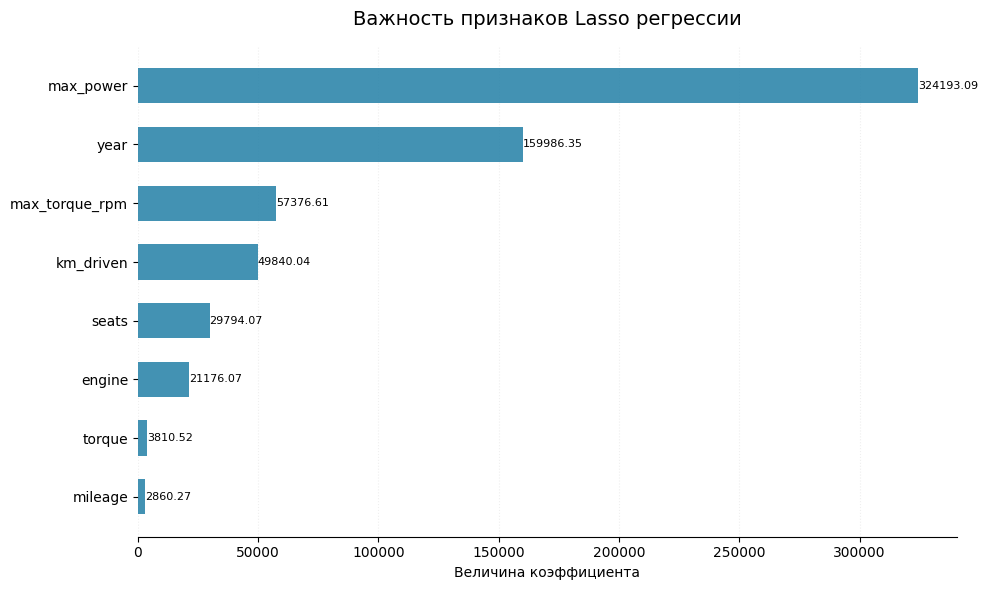

In [65]:
plot_coefs(lasso, "Lasso регрессии")

Веса не изменились практически никак. Скоры тоже. Все больше поводов для переживаний, что что-то пошло не так...

Вероятно, так случилось потому, что `все фичи важны`, даже в минимальной степени, поэтому мы и не увидели зануления.

**feature lives matters!**

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

Вернулся сюда из будущего, чтобы сразу сделать функцию. До последнего не хотел из-за количества параметров, но все таки лучше так, чем "репит йорселф" 20 раз :D

In [66]:
def grid_search_evaluation(
    model,
    params,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name,
    top,
    columns_df,
    cv: int = 10,
    verbose: int = False,
    log: bool = False,
    random_state: int = 42,
):
    if random_state:
        estimator = model(random_state=42)
    else:
        estimator = model()

    if log:
        y_train = np.log(y_train)

    gr_s = GridSearchCV(estimator, params, cv=cv, verbose=verbose)
    gr_s.fit(X_train, y_train)

    print("Лучшие параметры:", gr_s.best_params_)
    print("Лучший обнаруженный R2:", gr_s.best_score_)
    print()

    best_model = gr_s.best_estimator_

    best_model_pred = best_model.predict(X_test)

    if log:
        best_model_pred = np.exp(best_model_pred)

    print(f"R2 для {model_name}: {r2_score(y_test, best_model_pred)}")
    print(f"MSE для {model_name}: {mean_squared_error(y_test, best_model_pred)}")
    print("-----------------------")
    print("R2 начальный: 0.5976303092498518")
    print("MSE начальный: 231293588166.59518")

    plot_coefs(linear_model=best_model, model_name=model_name, df=columns_df, top=top)

    models_сount = 1

    for key, value in params.items():
        models_сount *= len(value)

    print(f"Кол-во обученных GridSearchCV моделей: {models_сount}")

    return best_model, best_model_pred

In [67]:
reg_coefs = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10, 100]

parameters = {
    "alpha": reg_coefs,
    "max_iter": [1000, 5000, 10000],
    "tol": [1e-4, 1e-5],
    "selection": ["cyclic", "random"],
}

Лучшие параметры: {'alpha': 100, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.0001}
Лучший обнаруженный R2: 0.5733904807676584

R2 для Lasso регрессии после подбора гиперпараметров: 0.5975079013916107
MSE для Lasso регрессии после подбора гиперпараметров: 231363951698.94672
-----------------------
R2 начальный: 0.5976303092498518
MSE начальный: 231293588166.59518


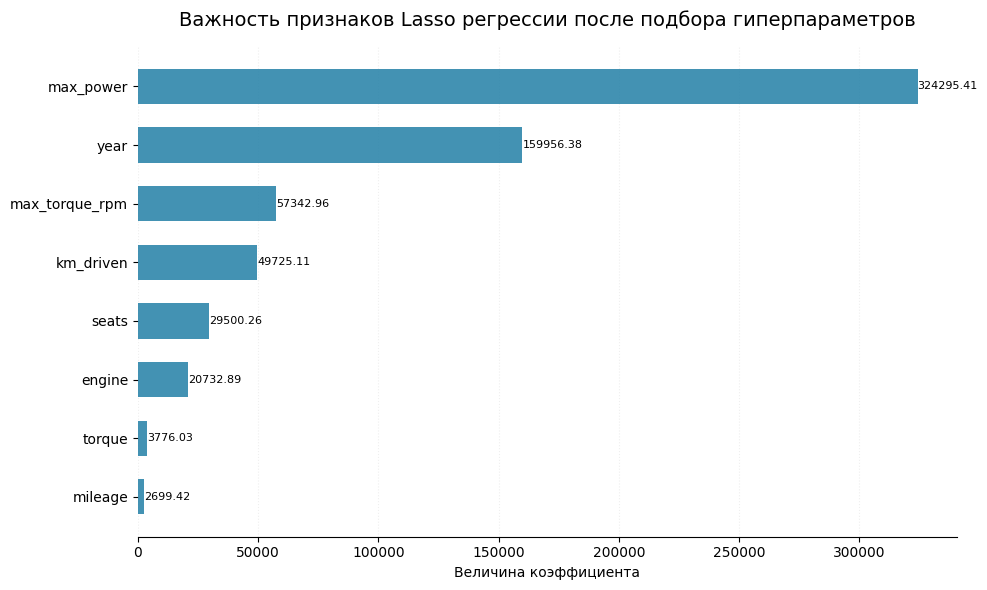

Кол-во обученных GridSearchCV моделей: 144


In [68]:
_, lasso_pred = grid_search_evaluation(
    model=Lasso,
    params=parameters,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Lasso регрессии после подбора гиперпараметров",
    columns_df=X_train,
    top=None,
)

In [69]:
predictions = {"lasso": lasso_pred}

По сути, победила просто обычная модель, но у которой выкручена регуляризация в сторону потолка.

Ответы на вопросы:
1. Пришлось обучать 144 модели
2. Параметры:
    * alpha - сила регуляризации
    * max_iter - максимальное число итераций
    * tol - точность решения (что-то вроде критерия остановки, если я правильно понял)
    * selection - стратегия обновления весов
3. Уже когда другие варианты не дали результата, попробовал поднять alpha аж до 100, но модели всё равно =/ Не меняется практически ничего.

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [70]:
parameters = {
    "alpha": reg_coefs,
    "l1_ratio": reg_coefs[:-5],  # для избежания ошибок
}  # оставил только основные параметры, потому что иначе уж слишком много моделей получается =)

Лучшие параметры: {'alpha': 0.5, 'l1_ratio': 0.75}
Лучший обнаруженный R2: 0.5797211197346913

R2 для ElasticNet регрессии после подбора гиперпараметров: 0.5704937628119652
MSE для ElasticNet регрессии после подбора гиперпараметров: 246892449960.50116
-----------------------
R2 начальный: 0.5976303092498518
MSE начальный: 231293588166.59518


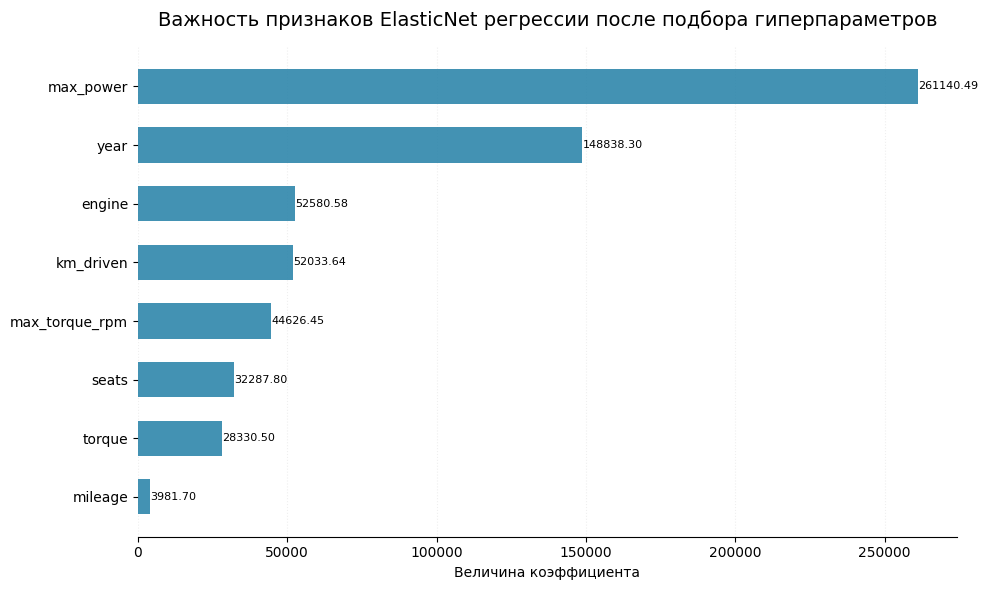

Кол-во обученных GridSearchCV моделей: 84


In [71]:
_, elastic_pred = grid_search_evaluation(
    model=ElasticNet,
    params=parameters,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="ElasticNet регрессии после подбора гиперпараметров",
    columns_df=X_train,
    top=None,
)

УРА, хоть что-то на графике коэффициентов заметно изменилось. Увеличилась важность turque =)

Лучшие параметры: `{'alpha': 0.5, 'l1_ratio': 0.75}`

In [72]:
predictions["elastic"] = elastic_pred

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



Честно, есть у меня сомнения по поводу того, что тут ожидалось от студента на самом деле, но сделаю так, как понимаю.

Знал, что однажды пригодится :D

[Моя самописная линейная регрессия (ссылка на гитхаб)](https://github.com/Aleksekek/HandWritten-ML-models/blob/main/LinearModels/LinearRegression/LinearRegression.py)

In [73]:
class MyLineReg:

    def __init__(
        self,
        n_iter=100,
        learning_rate=0.1,
        metric=None,
        reg=None,
        l0_coef=0,
        l1_coef=0,
        l2_coef=0,
        sgd_sample=None,
        random_state=42,
    ):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.metric = metric if metric else "r2"
        self.reg = reg
        self.l0_coef = l0_coef
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.sgd_sample = sgd_sample
        random.seed(random_state)
        self.weights = None

    def __repr__(self):
        return f"MyLineReg: n_iter={self.n_iter}, learning_rate={self.learning_rate}"

    def fit(self, X: pd.DataFrame, y: pd.Series, verbose: int = False):
        X = X.copy()
        X.reset_index(inplace=True, drop=True)
        X.insert(loc=0, column="x0", value=1)
        self.weights = np.ones(X.shape[1])

        for iter in range(1, self.n_iter + 1):

            if self.sgd_sample:
                if 0 < self.sgd_sample < 1:
                    sgd = round(self.sgd_sample * X.shape[0])
                else:
                    sgd = self.sgd_sample
                sample_rows_idx = random.sample(range(X.shape[0]), sgd)
                X_batch, y_batch = X.iloc[sample_rows_idx], y.iloc[sample_rows_idx]
            else:
                X_batch, y_batch = X, y

            pred = np.dot(X_batch, self.weights)
            grad = 2 * (np.dot((pred - y_batch), X_batch) / len(y_batch))

            if self.reg:
                if self.reg == "l1":
                    grad += self.l1_coef * np.sign(self.weights)
                if self.reg == "l2":
                    grad += self.l2_coef * 2 * self.weights
                if self.reg == "elasticnet":
                    grad += (
                        self.l1_coef * np.sign(self.weights)
                        + self.l2_coef * 2 * self.weights
                    )
                if self.reg == "l0":
                    grad += (
                        self.l0_coef
                        * np.sign(self.weights)
                        * (self.weights != 0).astype(float)
                    )

            if callable(self.learning_rate):
                lr = self.learning_rate(iter)
            else:
                lr = self.learning_rate

            self.weights -= grad * lr

            if verbose:

                if self.reg:
                    if self.reg == "l1":
                        reg = self.l1_coef * np.sum(np.abs(self.weights))
                    if self.reg == "l2":
                        reg = self.l2_coef * np.sum((self.weights) ** 2)
                    if self.reg == "elasticnet":
                        reg = self.l1_coef * np.sum(np.abs(self.weights))
                        reg += self.l2_coef * np.sum((self.weights) ** 2)
                else:
                    reg = 0

                if iter == 1:
                    pred = np.dot(X, np.ones(X.shape[1]))
                    loss = np.mean((pred - y) ** 2) + reg
                    res = f"start | loss: {loss}"
                    print_flag = True

                if iter % verbose == 0:
                    pred = np.dot(X, self.weights)
                    loss = np.mean((pred - y) ** 2) + reg
                    res = f"{iter} | loss: {loss}"
                    print_flag = True

                if self.metric and print_flag:
                    metric_val = self.metric_calc(pred, y)
                    res += f" | {self.metric}: {metric_val}"

                if callable(self.learning_rate) and print_flag:
                    res += f" | lr: {lr}"

                if print_flag:
                    print(res)
                    print_flag = False

        self.coef_ = self.weights[1:]

    def metric_calc(self, pred: pd.Series, y: pd.Series):
        if self.metric == "mae":
            return np.mean(np.abs(y - pred))
        if self.metric == "mse":
            return np.mean((y - pred) ** 2)
        if self.metric == "rmse":
            return np.mean((y - pred) ** 2) ** (1 / 2)
        if self.metric == "mape":
            return 100 * np.mean(np.abs((y - pred) / y))
        if self.metric == "r2":
            return 1 - (np.sum((y - pred) ** 2) / (np.sum((y - np.mean(y)) ** 2)))

    def predict(self, X: pd.DataFrame):
        X = X.copy()
        X.insert(loc=0, column="x0", value=1)
        pred = np.dot(X, self.weights)
        return pred

    def get_coef(self):
        return self.weights[1:]

    def score(self, X=None, y=None):
        return self.metric_calc(self.predict(X), y)

    def get_params(self, deep=True):
        params = {
            "n_iter": self.n_iter,
            "learning_rate": self.learning_rate,
            "metric": self.metric,
            "reg": self.reg,
            "l1_coef": self.l1_coef,
            "l2_coef": self.l2_coef,
            "l0_coef": self.l0_coef,
            "sgd_sample": self.sgd_sample,
        }
        return params

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(
                    f"Invalid parameter {key} for estimator {self.__class__.__name__}"
                )
        return self

По сути, просто добавил
```python
if self.reg == 'l0':
    grad += self.l0_coef * np.sign(self.weights) * (self.weights != 0).astype(float)
```
Потому что надо учитывать ненулевые веса + учет знаков для понимания направления.

Плюс реализовал (или чуть переписал) три последних метода, чтобы моделька стала совместима с GridSearchCV

In [74]:
parameters = {"l0_coef": reg_coefs, "reg": ["l0"]}

Лучшие параметры: {'l0_coef': 100, 'reg': 'l0'}
Лучший обнаруженный R2: 0.5734981863459756

R2 для l0 регрессии после подбора гиперпараметров: 0.5974580438928214
MSE для l0 регрессии после подбора гиперпараметров: 231392611212.96356
-----------------------
R2 начальный: 0.5976303092498518
MSE начальный: 231293588166.59518


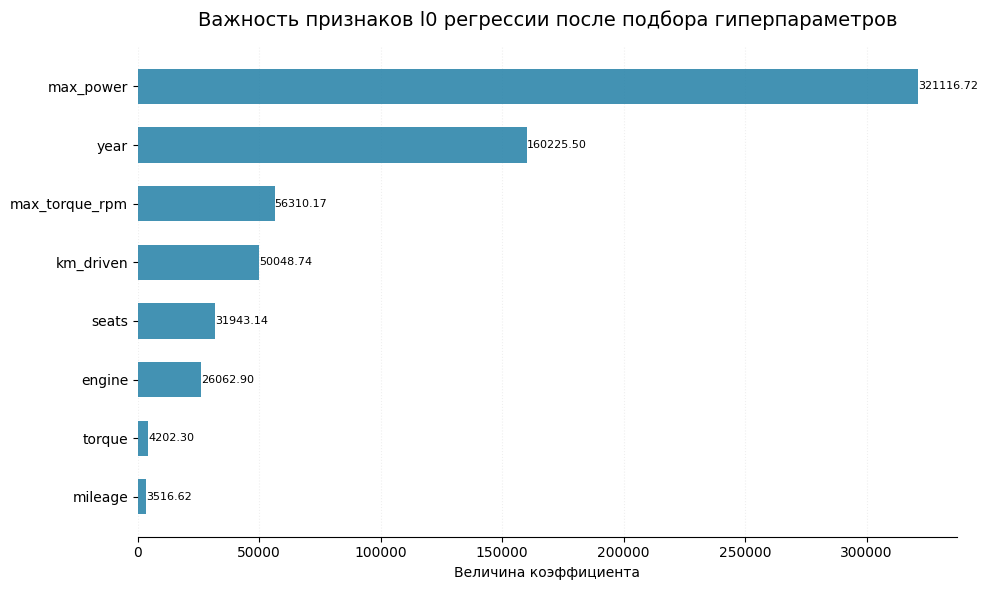

Кол-во обученных GridSearchCV моделей: 12


In [75]:
_, l0_pred = grid_search_evaluation(
    model=MyLineReg,
    params=parameters,
    X_train=pd.DataFrame(X_train_scaled),
    y_train=y_train,
    X_test=pd.DataFrame(X_test_scaled),
    y_test=y_test,
    model_name="l0 регрессии после подбора гиперпараметров",
    columns_df=X_train,
    top=None,
)

In [76]:
predictions["l0"] = l0_pred

Вот и спрашивается, чего мучались XD

## **Вывод по части 2**

`Линейные модели` (с регуляризацией и без), обученные только на числовых фичах, имеют `$R^2$` примерно на уровне `0.57-0.59`.

Ни один из опробованных видов регуляризации сильно не изменил распределение важности признаков, а l0 не занулил ни один из них. 

Масштабирование признаков не дало ощутимых сдвигов в прогнозировании, но позволило провести аналз признаков на эту самую важность. 

Самым важным признаком по результатам этого этапа работы является `max_power`.

В следующей части попробуем улучшить модель за счет работы с категориальными фичами.

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [77]:
df_train["name"].apply(lambda x: str(x).split()[0]).unique()

array(['Maruti', 'Skoda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Honda', 'Chevrolet', 'Fiat', 'Datsun', 'Tata', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Isuzu', 'Peugeot'], dtype=object)

Попросил у deepseek проверить, все ли тут автобренды и нет ли чего лишнего, он подтвердил, что все ок, кроме:

```text
Land — это часть бренда Land Rover, поэтому он не лишний, но записан некорректно.
Force — это бренд коммерческих, а не легковых автомобилей, поэтому его можно считать лишним в данном контексте.
```

В общем-то, это все не лишнее, удалять мы ничего не будем, а проблем с тем, что это одно слово, а не два, для нас не возникнет, так как, к счастью, дубликатов не видно.
В общем, так столбец и обработаем.

In [78]:
X_train_cat = X_train.copy()
X_train_cat["name"] = df_train["name"].apply(lambda x: str(x).split()[0])

In [79]:
X_train_cat = pd.concat(
    [X_train_cat, df_train[["fuel", "seller_type", "transmission", "owner"]]], axis=1
)

In [80]:
X_train_cat

,year,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm,name,fuel,seller_type,transmission,owner
0,2014,145500,23.40,1248,74.00,190.000000,5,2000.0,Maruti,Diesel,Individual,Manual,First Owner
1,2014,120000,21.14,1498,103.52,250.000000,5,1500.0,Skoda,Diesel,Individual,Manual,Second Owner
2,2010,127000,23.00,1396,90.00,219.668960,5,1750.0,Hyundai,Diesel,Individual,Manual,First Owner
3,2007,120000,16.10,1298,88.20,112.776475,5,4500.0,Maruti,Petrol,Individual,Manual,First Owner
4,2017,45000,20.14,1197,81.86,113.750000,5,4000.0,Hyundai,Petrol,Individual,Manual,First Owner
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,2008,191000,17.92,1086,62.10,96.100000,5,3000.0,Hyundai,Petrol,Individual,Manual,First Owner
5836,2013,50000,18.90,998,67.10,90.000000,5,3500.0,Maruti,Petrol,Individual,Manual,Second Owner
5837,2013,110000,18.50,1197,82.85,113.700000,5,4000.0,Hyundai,Petrol,Individual,Manual,First Owner
5838,2007,119000,16.80,1493,110.00,235.359600,5,1900.0,Hyundai,Diesel,Individual,Manual,Fourth & Above Owner


In [81]:
# assert X_train_cat.shape == (5840, 11)

Честно, не знаю, откуда тут в assert'е значение 11.

11 можно получить, если из самого первого (до любых манипуляций) датафрейма вырезать target и name. Но мы как минимум делили столбец torque на 2, а также пришли к этому этапу имея датафрейм только из числовых фичей. Добавив в него фичу от обработки name (о чем прямо в задании и написано), получаем 9 фичей.

Если к ним сразу добавить все остальные категориальные фичи (о чем в задании явно не написано, но упомянуто перед ним), то получается 13. В среднем, конечно, как раз 11, но что-то так себе =/

В общем, опишите мне, пожалуйста, в ревью, где я поступил сильно не так. Возможно изначально пропустил где-то ошибку, поэтому на прошлых шагах и прогнозы не менялись, и важности фичей (хотя то, что они не менялись - и не проблема само по себе от слова совсем). Честно, не понял этот момент. Пока просто закомментирую ассерт...

In [82]:
X_train_cat.describe(include="object")

,name,fuel,seller_type,transmission,owner
count,5840,5840,5840,5840,5840
unique,30,4,3,2,5
top,Maruti,Diesel,Individual,Manual,First Owner
freq,1804,3177,5223,5336,3603


То же самое проделаем для теста.

In [83]:
X_test_cat = X_test.copy()
X_test_cat["name"] = df_test["name"].apply(lambda x: str(x).split()[0])
X_test_cat = pd.concat(
    [X_test_cat, df_test[["fuel", "seller_type", "transmission", "owner"]]], axis=1
)

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

Сделал сначала через get_dummies, потом воткнулся в то, что, конечно же, в тесте есть марки, которых не было в трейне, поэтому чтобы не мучать дальше код, переделал быстро на ohe с игнорированием ошибок. Сделал через DEEPSEEK.

In [84]:
# или можно использовать get_dummies из библиотеки pandas

ohe = OneHotEncoder(
    drop="first", dtype=int, sparse_output=False, handle_unknown="ignore"
)
X_train_cat_ohe = ohe.fit_transform(
    X_train_cat[["seats", "name", "fuel", "seller_type", "transmission", "owner"]]
)

# Преобразуем результат обратно в DataFrame с правильными названиями колонок
feature_names = ohe.get_feature_names_out(
    ["seats", "name", "fuel", "seller_type", "transmission", "owner"]
)
ohe_features = pd.DataFrame(
    X_train_cat_ohe, columns=feature_names, index=X_train_cat.index
)

# Объединяем с числовыми признаками
X_train_cat = pd.concat(
    [
        X_train_cat[
            [
                "year",
                "km_driven",
                "mileage",
                "engine",
                "max_power",
                "torque",
                "max_torque_rpm",
            ]
        ],
        ohe_features,
    ],
    axis=1,
)
X_train_cat

,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,seats_4,seats_5,seats_6,...,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,145500,23.40,1248,74.00,190.000000,2000.0,0,1,0,...,1,0,0,1,0,1,0,0,0,0
1,2014,120000,21.14,1498,103.52,250.000000,1500.0,0,1,0,...,1,0,0,1,0,1,0,1,0,0
2,2010,127000,23.00,1396,90.00,219.668960,1750.0,0,1,0,...,1,0,0,1,0,1,0,0,0,0
3,2007,120000,16.10,1298,88.20,112.776475,4500.0,0,1,0,...,0,0,1,1,0,1,0,0,0,0
4,2017,45000,20.14,1197,81.86,113.750000,4000.0,0,1,0,...,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,2008,191000,17.92,1086,62.10,96.100000,3000.0,0,1,0,...,0,0,1,1,0,1,0,0,0,0
5836,2013,50000,18.90,998,67.10,90.000000,3500.0,0,1,0,...,0,0,1,1,0,1,0,1,0,0
5837,2013,110000,18.50,1197,82.85,113.700000,4000.0,0,1,0,...,0,0,1,1,0,1,0,0,0,0
5838,2007,119000,16.80,1493,110.00,235.359600,1900.0,0,1,0,...,1,0,0,1,0,1,1,0,0,0


In [85]:
# Применяем уже обученный encoder к тестовым данным
X_test_cat_ohe = ohe.transform(
    X_test_cat[["seats", "name", "fuel", "seller_type", "transmission", "owner"]]
)

# Преобразуем результат обратно в DataFrame
ohe_features_test = pd.DataFrame(
    X_test_cat_ohe, columns=feature_names, index=X_test_cat.index
)

# Объединяем с числовыми признаками
X_test_cat = pd.concat(
    [
        X_test_cat[
            [
                "year",
                "km_driven",
                "mileage",
                "engine",
                "max_power",
                "torque",
                "max_torque_rpm",
            ]
        ],
        ohe_features_test,
    ],
    axis=1,
)
X_test_cat

,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,seats_4,seats_5,seats_6,...,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2010,168000,14.00,2498,112.00,260.00000,1800.0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,2017,25000,21.50,1497,108.50,260.00000,1500.0,0,1,0,...,1,0,0,1,0,1,0,0,0,0
2,2007,218463,12.90,1799,130.00,172.00000,4300.0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
3,2015,173000,25.10,1498,98.60,200.00000,1750.0,0,1,0,...,1,0,0,1,0,1,0,0,0,0
4,2011,70000,16.50,1172,65.00,96.00000,3000.0,0,1,0,...,0,0,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2008,100000,19.81,1086,68.05,99.04000,4500.0,0,1,0,...,0,0,1,1,0,1,0,1,0,0
996,2017,50000,18.60,1197,81.83,114.70000,4000.0,0,1,0,...,0,0,1,1,0,1,0,1,0,0
997,2009,40000,23.00,1396,90.00,219.66896,1750.0,0,1,0,...,1,0,0,1,0,1,0,0,0,0
998,2012,25000,20.36,1197,78.90,111.80000,4000.0,0,1,0,...,0,0,1,1,0,1,0,0,0,0


### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

`Your answer here`

Ответы:
1. Для корректной работы я сразу применяю drop_first = True и использую числовой тип
2. Чтобы избежать dummy ловушки, также известной, как мультиколлинеарность.
3. Как показывает практика, если нет жесткой необходимости, то лучше вообще ничего не удалять, потому что скор может проседать. В остальном, скорее всего, совсем работоспособность это не сломает, если мы уже не в dummy ловушке. Однако тут очень важно отметить, что если мы что-то удаляем, то удалять это потом необходимо уже везде. Если удалим в трейне, но забудем про тест, будет очень неприятный сюрприз в виде падения с ошибкой. Потому что, по сути, мы выкидываем категории в этот момент.

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

Перед этим применю StandartScaler для чистоты эксперимента.

In [86]:
sc_full = StandardScaler()
X_train_cat_scaled = sc_full.fit_transform(X_train_cat)
X_test_cat_scaled = sc_full.transform(X_test_cat)

In [87]:
parameters = {"alpha": reg_coefs}

Лучшие параметры: {'alpha': 100}
Лучший обнаруженный R2: 0.7091494054430008

R2 для Ridge регрессии после добавления категориальных фичей: 0.7852624954763626
MSE для Ridge регрессии после добавления категориальных фичей: 123437249566.72641
-----------------------
R2 начальный: 0.5976303092498518
MSE начальный: 231293588166.59518


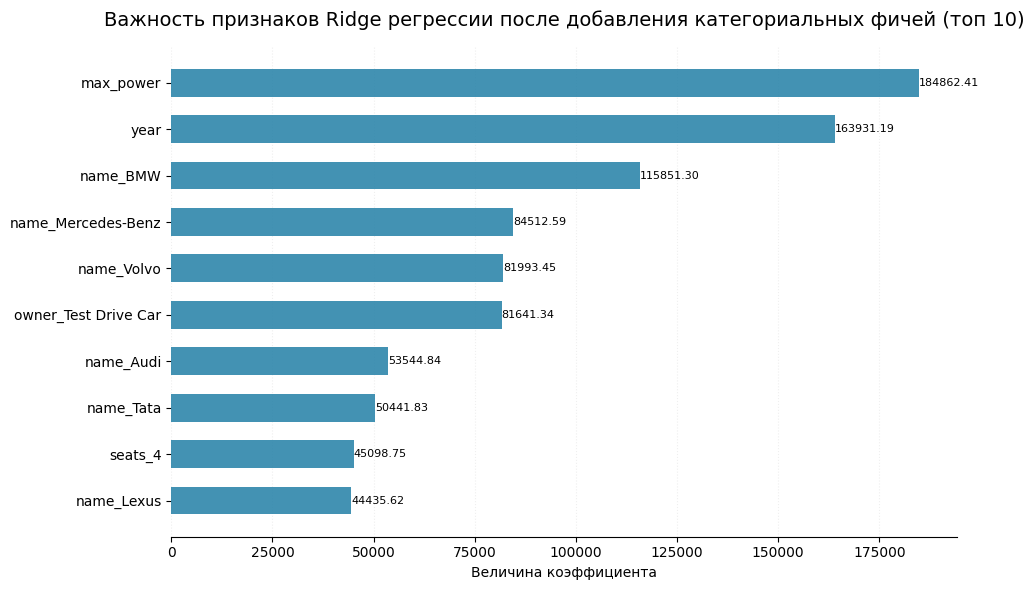

Кол-во обученных GridSearchCV моделей: 12


In [88]:
_, ridge_pred = grid_search_evaluation(
    model=Ridge,
    params=parameters,
    X_train=X_train_cat_scaled,
    y_train=y_train,
    X_test=X_test_cat_scaled,
    y_test=y_test,
    model_name="Ridge регрессии после добавления категориальных фичей",
    columns_df=X_train_cat,
    top=10,
)

In [89]:
predictions["ridge"] = ridge_pred

Качество наконец-то ощутимо вырасло!) Победа, радуемся и идем улучшать прогнозы дальше.

## **Вывод по части 3**

`Добавление категориальных признаков` ощутимо `улучшило результаты` модели - `с 0.57 до 0.78`.

Самым важным признаком на данный момент остается `max_power`.

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

Итак, нам нужен план...
1. Новые признаки:
    * Раз в самом задании намекают на то, что надо брать квадраты, будем брать квадраты =) А ещё синусоиду, потому что кто мне запретит...
    * Произведения некоторых фичей.
    * Во время обработки названий, deepseek мне случайно ещё и страны производителей написал. А мне идея показалась интересной, поэтому почему бы не добавить таких фичей.
2. Логарифмирование таргета. Ранее мысль об этом уже была, пришло время ей воспользоваться.

Проделаем эти шаги, а там будет видно, куда двигаться дальше.

`НО!` я перепрокручу весь пайплайн обработки ещё раз, чтобы внести изменения в нужные моменты и подготовить почву для будущего пайплайна.

Также далее будет использован DEEPSEEK, потому что вручную это все выписывать будет достаточно долго.

In [90]:
brand_country = {
    "Maruti": "India",  # Maruti Suzuki - индийская дочка Suzuki
    "Skoda": "Czech Republic",
    "Hyundai": "South Korea",
    "Toyota": "Japan",
    "Ford": "USA",
    "Renault": "France",
    "Mahindra": "India",
    "Honda": "Japan",
    "Chevrolet": "USA",  # Бренд General Motors
    "Fiat": "Italy",
    "Datsun": "Japan",  # Возрождённый бюджетный бренд Nissan
    "Tata": "India",
    "Jeep": "USA",
    "Mercedes-Benz": "Germany",
    "Mitsubishi": "Japan",
    "Audi": "Germany",
    "Volkswagen": "Germany",
    "BMW": "Germany",
    "Nissan": "Japan",
    "Lexus": "Japan",  # Премиальный бренд Toyota
    "Jaguar": "UK",
    "Land": "UK",  # Имеется в виду Land Rover
    "MG": "UK/China",  # Исторически британский, сейчас китайский (SAIC)
    "Volvo": "Sweden",  # Принадлежит китайской Geely
    "Daewoo": "South Korea",  # Исторический бренд, сейчас не существует
    "Kia": "South Korea",
    "Force": "India",  # Коммерческие автомобили
    "Ambassador": "India",  # Hindustan Ambassador
    "Isuzu": "Japan",
    "Peugeot": "France",
}

In [91]:
# Создаем копию исходных данных для feature engineering
X_train_fe = X_train.copy()
X_train_fe["name"] = df_train["name"].apply(lambda x: str(x).split()[0])

# Добавляем страну производителя
X_train_fe["country"] = X_train_fe["name"].map(brand_country)

# Объединяем с категориальными признаками
X_train_fe = pd.concat(
    [X_train_fe, df_train[["fuel", "seller_type", "transmission", "owner"]]], axis=1
)

# 1. КВАДРАТЫ ОСНОВНЫХ ЧИСЛОВЫХ ПРИЗНАКОВ
numerical_features = [
    "year",
    "km_driven",
    "mileage",
    "engine",
    "max_power",
    "torque",
    "max_torque_rpm",
]

for feature in numerical_features:
    X_train_fe[f"{feature}_squared"] = X_train_fe[feature] ** 2

# 2. СИНУСОИДЫ ЧИСЛОВЫХ ПРИЗНАКОВ (нормализованных)
for feature in numerical_features:
    # Нормализуем перед применением синуса
    normalized = (X_train_fe[feature] - X_train_fe[feature].mean()) / X_train_fe[
        feature
    ].std()
    X_train_fe[f"{feature}_sin"] = np.sin(normalized)

# 3. ЛОГАРИФМЫ ЧИСЛОВЫХ ПРИЗНАКОВ (с защитой от отрицательных значений)
for feature in numerical_features:
    # Добавляем константу, чтобы избежать логарифмирования неположительных чисел
    min_val = X_train_fe[feature].min()
    if min_val <= 0:
        constant = abs(min_val) + 1  # Добавляем константу, чтобы все значения были > 0
    else:
        constant = 0

    X_train_fe[f"{feature}_log"] = np.log(X_train_fe[feature] + constant)

# 4. ПРОИЗВЕДЕНИЯ ВЗАИМОСВЯЗАННЫХ ПРИЗНАКОВ
X_train_fe["mileage_torque"] = X_train_fe["mileage"] * X_train_fe["torque"]
X_train_fe["km_driven_mileage"] = X_train_fe["km_driven"] * X_train_fe["mileage"]
X_train_fe["max_power_max_torque_rpm"] = (
    X_train_fe["max_power"] * X_train_fe["max_torque_rpm"]
)
X_train_fe["engine_max_power"] = X_train_fe["engine"] * X_train_fe["max_power"]
X_train_fe["year_mileage"] = X_train_fe["year"] * X_train_fe["mileage"]
X_train_fe["year_max_power"] = X_train_fe["year"] * X_train_fe["max_power"]
X_train_fe["year_engine"] = X_train_fe["year"] * X_train_fe["engine"]
X_train_fe["torque_rpm_ratio"] = X_train_fe["torque"] / (
    X_train_fe["max_torque_rpm"] + 1e-8
)

# 5. КВАДРАТЫ ПРОИЗВЕДЕНИЙ (для самых важных взаимодействий)
interaction_features = [
    "mileage_torque",
    "km_driven_mileage",
    "max_power_max_torque_rpm",
    "engine_max_power",
    "year_max_power",
]

for feature in interaction_features:
    X_train_fe[f"{feature}_squared"] = X_train_fe[feature] ** 2

# 6. OHE для категориальных признаков (включая новую колонку country)
ohe = OneHotEncoder(
    drop="first", dtype=int, sparse_output=False, handle_unknown="ignore"
)
X_train_cat_ohe = ohe.fit_transform(
    X_train_fe[
        ["seats", "name", "fuel", "seller_type", "transmission", "owner", "country"]
    ]
)

# Преобразуем результат обратно в DataFrame с правильными названиями колонок
feature_names = ohe.get_feature_names_out(
    ["seats", "name", "fuel", "seller_type", "transmission", "owner", "country"]
)
ohe_features = pd.DataFrame(
    X_train_cat_ohe, columns=feature_names, index=X_train_fe.index
)

# 7. ВЫДЕЛЯЕМ ВСЕ ЧИСЛОВЫЕ ПРИЗНАКИ (оригинальные + новые)
numerical_columns = (
    ["year", "km_driven", "mileage", "engine", "max_power", "torque", "max_torque_rpm"]
    + [f"{feat}_squared" for feat in numerical_features]
    + [f"{feat}_sin" for feat in numerical_features]
    + [f"{feat}_log" for feat in numerical_features]
    + [
        "mileage_torque",
        "km_driven_mileage",
        "max_power_max_torque_rpm",
        "engine_max_power",
        "year_mileage",
        "year_max_power",
        "year_engine",
        "torque_rpm_ratio",
    ]
    + [f"{feat}_squared" for feat in interaction_features]
)

# Объединяем числовые признаки с OHE-признаками
X_train_final = pd.concat([X_train_fe[numerical_columns], ohe_features], axis=1)

# 8. МАСШТАБИРОВАНИЕ
sc_full = StandardScaler()
X_train_scaled = sc_full.fit_transform(X_train_final)

print(f"Итоговый размер датасета: {X_train_scaled.shape}")

Итоговый размер датасета: (5840, 98)


In [92]:
# Аналогичные преобразования для тестовых данных
X_test_fe = X_test.copy()
X_test_fe["name"] = df_test["name"].apply(lambda x: str(x).split()[0])
X_test_fe["country"] = X_test_fe["name"].map(brand_country)
X_test_fe = pd.concat(
    [X_test_fe, df_test[["fuel", "seller_type", "transmission", "owner"]]], axis=1
)

# Применяем те же feature engineering преобразования
for feature in numerical_features:
    X_test_fe[f"{feature}_squared"] = X_test_fe[feature] ** 2

for feature in numerical_features:
    normalized = (X_test_fe[feature] - X_train_fe[feature].mean()) / X_train_fe[
        feature
    ].std()
    X_test_fe[f"{feature}_sin"] = np.sin(normalized)

# Логарифмы с теми же константами, что и в тренировочных данных
for feature in numerical_features:
    min_val = X_train_fe[feature].min()  # Используем минимум из тренировочных данных!
    if min_val <= 0:
        constant = abs(min_val) + 1
    else:
        constant = 0

    X_test_fe[f"{feature}_log"] = np.log(X_test_fe[feature] + constant)

# Произведения
X_test_fe["mileage_torque"] = X_test_fe["mileage"] * X_test_fe["torque"]
X_test_fe["km_driven_mileage"] = X_test_fe["km_driven"] * X_test_fe["mileage"]
X_test_fe["max_power_max_torque_rpm"] = (
    X_test_fe["max_power"] * X_test_fe["max_torque_rpm"]
)
X_test_fe["engine_max_power"] = X_test_fe["engine"] * X_test_fe["max_power"]
X_test_fe["year_mileage"] = X_test_fe["year"] * X_test_fe["mileage"]
X_test_fe["year_max_power"] = X_test_fe["year"] * X_test_fe["max_power"]
X_test_fe["year_engine"] = X_test_fe["year"] * X_test_fe["engine"]
X_test_fe["torque_rpm_ratio"] = X_test_fe["torque"] / (
    X_test_fe["max_torque_rpm"] + 1e-8
)

# Квадраты произведений
for feature in interaction_features:
    X_test_fe[f"{feature}_squared"] = X_test_fe[feature] ** 2

# OHE и масштабирование
X_test_cat_ohe = ohe.transform(
    X_test_fe[
        ["seats", "name", "fuel", "seller_type", "transmission", "owner", "country"]
    ]
)
X_test_ohe_features = pd.DataFrame(
    X_test_cat_ohe, columns=feature_names, index=X_test_fe.index
)
X_test_final = pd.concat([X_test_fe[numerical_columns], X_test_ohe_features], axis=1)
X_test_scaled = sc_full.transform(X_test_final)

print(f"Итоговый размер датасета: {X_test_scaled.shape}")

Итоговый размер датасета: (1000, 98)


In [93]:
parameters = {
    "alpha": [0.1, 1.0, 10.0, 100.0],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    "max_iter": [10000],
    "tol": [0.01],
}

Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.7, 'max_iter': 10000, 'tol': 0.01}
Лучший обнаруженный R2: 0.7585772591877806

R2 для ElasticNet регрессии после feature_engineering: 0.8088427370918867
MSE для ElasticNet регрессии после feature_engineering: 109882653337.26917
-----------------------
R2 начальный: 0.5976303092498518
MSE начальный: 231293588166.59518


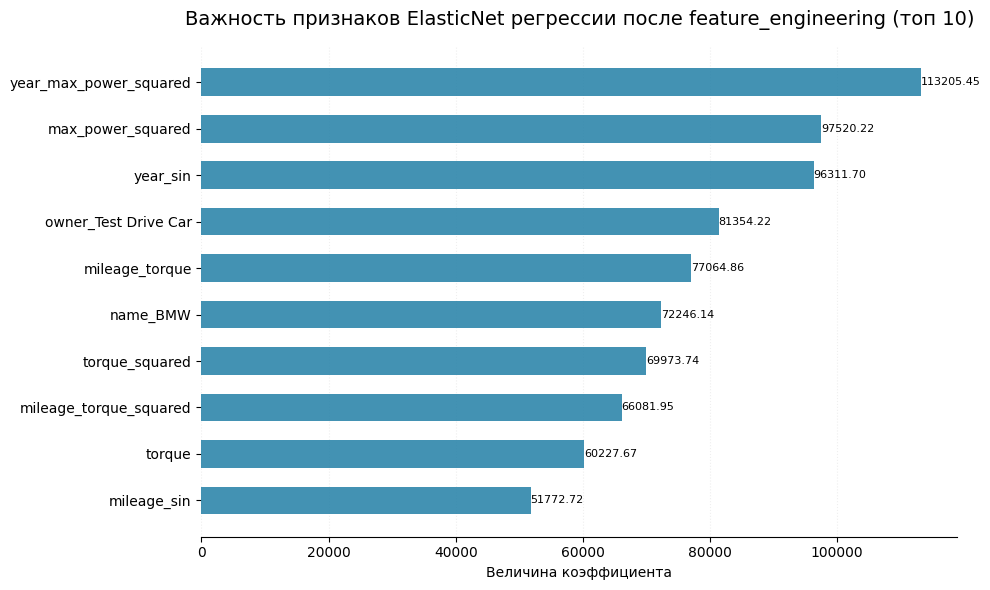

Кол-во обученных GridSearchCV моделей: 20


In [94]:
_, elastic_fe_pred = grid_search_evaluation(
    model=ElasticNet,
    params=parameters,
    X_train=pd.DataFrame(X_train_scaled),
    y_train=y_train,
    X_test=pd.DataFrame(X_test_scaled),
    y_test=y_test,
    model_name="ElasticNet регрессии после feature_engineering",
    columns_df=X_train_final,
    top=10,
    cv=10,
)

In [95]:
predictions["elastic_fe"] = elastic_fe_pred

R2 подрос, но мы ещё не протестировали логарифмирование. Пришло время пробовать!)

Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 10000, 'tol': 0.01}
Лучший обнаруженный R2: 0.8812821108466323

R2 для ElasticNet регрессии c логарифмированием таргета: 0.8378813581998951
MSE для ElasticNet регрессии c логарифмированием таргета: 93190424708.02065
-----------------------
R2 начальный: 0.5976303092498518
MSE начальный: 231293588166.59518


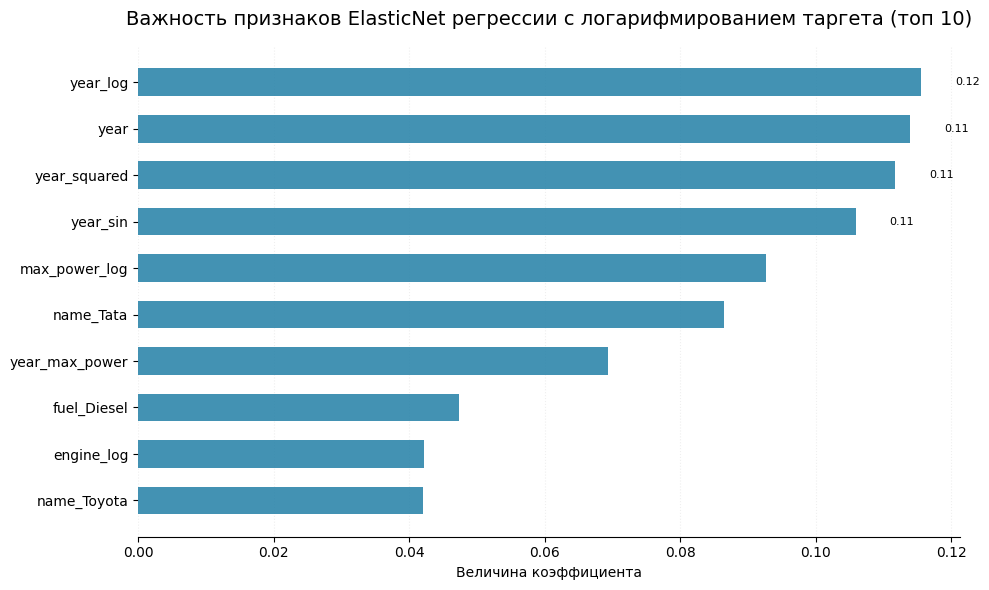

Кол-во обученных GridSearchCV моделей: 20


In [96]:
elasticnet_log, elastic_log_pred = grid_search_evaluation(
    model=ElasticNet,
    params=parameters,
    X_train=pd.DataFrame(X_train_scaled),
    y_train=y_train,
    X_test=pd.DataFrame(X_test_scaled),
    y_test=y_test,
    model_name="ElasticNet регрессии c логарифмированием таргета",
    columns_df=X_train_final,
    top=10,
    cv=10,
    log=True,
)

In [97]:
predictions["elastic_log"] = elastic_log_pred

Итого, за эту секцию наш R2 подрос с `0.7852` до `0.8379`. Достаточно неплохой результат для линейной модели!)

Так как это не хакатон, позволю себе остановиться на достигнутом и перейти к следующей части :D

**Сохраняем лучшую модель**

In [98]:
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

In [99]:
if False:  # При желании сохранить, заменить на True
    model_path = os.path.join(model_dir, "elasticnet_model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(elasticnet_log, f, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"✅ Модель сохранена: {model_path}")

## **Вывод по части 4**

Добавление квадратов, синусов и логарифмов от признаков, создание нескольких производных признаков (произведение базовых), добавление категориального признака страны производителя, а также логарифмирование таргета позволили улучшить модель с `0.7852` до `0.8379` по метрике $R^2$.

Самым важным признаком (даже не одним, а 4 самыми важными) оказаласась производная от `year`. Неожиданный результат, но модели виднее :D

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [100]:
def business_metrics(y_true, y_pred):
    masked_pred = (y_pred >= y_true * 0.9) & (y_pred <= y_true * 1.1)
    return np.sum(masked_pred) / len(y_true)

In [101]:
for key, value in predictions.items():
    print(f"Бизнес метрика для модели {key}: {business_metrics(y_test, value)}")

Бизнес метрика для модели lasso: 0.238
Бизнес метрика для модели elastic: 0.252
Бизнес метрика для модели l0: 0.237
Бизнес метрика для модели ridge: 0.312
Бизнес метрика для модели elastic_fe: 0.296
Бизнес метрика для модели elastic_log: 0.342


Что ж, мучения с feature engineering'ом прошли не зря, эта модель и победила =)

Однако стоит отметить, что скор все равно достаточно невысокий. Связано это с тем, что отклонения происходят даже у лучшей модели в среднем процентов на 20. Можно добивать скор и выше, но в данном случае это как будто совершенно избыточно. Если бы правда нужен был скор выше, просто взяли бы модель лучше. Так что запишем себе это не как поражение, а как сознательную оптимизацию затраченного времени и усилий :D

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [102]:
def your_business_metrics(y_true, y_pred):
    diff = y_pred - y_true
    relative_errors = diff / (y_true + 1e-8)

    penalties = np.where(
        relative_errors < 0, np.exp(-1.5 * relative_errors) - 1, np.abs(relative_errors)
    )

    return 1 - np.mean(penalties)

Идея метрики в том, чтобы штрафовать экспоненциально при недопрогнозе и линейно при перепрогнозе.

Использовал DEEPSEEK, чтобы он нормально условие np.where прописал.

In [103]:
for key, value in predictions.items():
    print(f"Бизнес метрика для модели {key}: {your_business_metrics(y_test, value)}")

Бизнес метрика для модели lasso: -99403281.50576739
Бизнес метрика для модели elastic: -2819192.1575368703
Бизнес метрика для модели l0: -101114777.52054344
Бизнес метрика для модели ridge: -229.94098037806503
Бизнес метрика для модели elastic_fe: -0.25931657588569434
Бизнес метрика для модели elastic_log: 0.7271519064863579


Судя по полученной метрике, наша финальная модель как раз любит переоценивать больше, чем недооценивать. Супер, бизнес доволен :D

(ладно, она просто работает точнее)

# **Часть 4.5 | Сборка пайплайна**

Добавил эту часть, чтобы как-то отделить логику сборки пайплайна, который точно понадобится дальше, для создания стримлит приложения.

P.S. Класс собран с помощью DEEPSEEK и 10 раз правился вручную, потому что deepseek лучше вообще не использовать для кодинга, но я его слишком люблю =(

По сути, представляет собой просто собранное всё в одном месте, что для преобразований собиралось в течение всего ноутбука.

In [104]:
class CarDataPreprocessor:
    def __init__(self, brand_country_mapping, numerical_features, interaction_features):
        self.brand_country_mapping = brand_country_mapping
        self.numerical_features = numerical_features
        self.interaction_features = interaction_features

        self.medians = {}
        self.train_means = {}
        self.train_stds = {}
        self.train_mins = {}
        self.ohe = None
        self.scaler = None
        self.feature_names = None
        self.final_feature_names_ = None

    def parse_torque(self, torque_str):
        if pd.isna(torque_str) or str(torque_str).strip() in ["", "torque"]:
            return np.nan, np.nan

        torque_str = str(torque_str).strip()
        numbers = re.findall(r"(\d+\.?\d*)", torque_str.replace(",", ""))

        torque_val = np.nan
        rpm_val = np.nan

        if len(numbers) >= 1:
            torque_val = float(numbers[0])
            if "kgm" in torque_str.lower() or "kg" in torque_str.lower():
                torque_val = torque_val * 9.80665

        if len(numbers) >= 2:
            rpm_val = float(numbers[1])

        return torque_val, rpm_val

    def fix_column_types(self, df):
        """Исправление типов колонок"""
        fixed_df = df.copy()

        # Mileage
        fixed_df["mileage"] = fixed_df["mileage"].apply(
            lambda x: (
                float(str(x).split()[0])
                if str(x).endswith("kmpl") and x.strip() != "kmpl"
                else (
                    float(str(x).split()[0]) * 1.40
                    if str(x).endswith("km/kg") and x.strip() != "km/kg"
                    else np.nan
                )
            )
        )

        # Engine
        fixed_df["engine"] = fixed_df["engine"].apply(
            lambda x: (
                float(str(x).split()[0])
                if str(x).endswith("CC") and x.strip() != "CC"
                else np.nan
            )
        )

        # Max Power
        fixed_df["max_power"] = fixed_df["max_power"].apply(
            lambda x: (
                float(str(x).split()[0])
                if str(x).endswith("bhp") and x.strip() != "bhp"
                else np.nan
            )
        )

        # Torque
        torque_results = fixed_df["torque"].apply(self.parse_torque)
        fixed_df["torque"] = torque_results.apply(lambda x: x[0])
        fixed_df["max_torque_rpm"] = torque_results.apply(lambda x: x[1])

        return fixed_df

    def extract_brand_and_country(self, df):
        """Извлечение бренда и страны"""
        df_fe = df.copy()
        df_fe["name"] = df_fe["name"].apply(lambda x: str(x).split()[0])
        df_fe["country"] = df_fe["name"].map(self.brand_country_mapping)
        return df_fe

    def create_polynomial_features(self, df):
        """Создание полиномиальных features"""
        df_fe = df.copy()

        # Квадраты
        for feature in self.numerical_features:
            if feature in df_fe.columns:
                df_fe[f"{feature}_squared"] = df_fe[feature] ** 2

        # Нормализация + sin
        for feature in self.numerical_features:
            if (
                feature in df_fe.columns
                and hasattr(self, "train_means")
                and feature in self.train_means
            ):
                if self.train_stds[feature] != 0:
                    normalized = (
                        df_fe[feature] - self.train_means[feature]
                    ) / self.train_stds[feature]
                    df_fe[f"{feature}_sin"] = np.sin(normalized)
                else:
                    df_fe[f"{feature}_sin"] = 0

        return df_fe

    def create_log_features(self, df):
        """Создание логарифмических features"""
        df_fe = df.copy()

        for feature in self.numerical_features:
            if (
                feature in df_fe.columns
                and hasattr(self, "train_mins")
                and feature in self.train_mins
            ):
                min_val = self.train_mins[feature]
                constant = abs(min_val) + 1 if min_val <= 0 else 0
                # Защита от логарифма неположительных чисел
                values = df_fe[feature] + constant
                values = np.where(values <= 0, 1e-10, values)
                df_fe[f"{feature}_log"] = np.log(values)

        return df_fe

    def create_interaction_features(self, df):
        """Создание interaction features"""
        df_fe = df.copy()

        # Базовые взаимодействия
        interaction_pairs = [
            ("mileage", "torque"),
            ("km_driven", "mileage"),
            ("max_power", "max_torque_rpm"),
            ("engine", "max_power"),
            ("year", "mileage"),
            ("year", "max_power"),
            ("year", "engine"),
        ]

        for col1, col2 in interaction_pairs:
            if col1 in df_fe.columns and col2 in df_fe.columns:
                df_fe[f"{col1}_{col2}"] = df_fe[col1] * df_fe[col2]

        if "torque" in df_fe.columns and "max_torque_rpm" in df_fe.columns:
            df_fe["torque_rpm_ratio"] = df_fe["torque"] / (
                df_fe["max_torque_rpm"] + 1e-8
            )

        # Квадраты взаимодействий
        for feature in self.interaction_features:
            if feature in df_fe.columns:
                df_fe[f"{feature}_squared"] = df_fe[feature] ** 2

        return df_fe

    def _apply_all_feature_engineering(self, df):
        """Применение всего feature engineering"""
        df_fe = df.copy()
        df_fe = self.extract_brand_and_country(df_fe)
        df_fe = self.create_polynomial_features(df_fe)
        df_fe = self.create_log_features(df_fe)
        df_fe = self.create_interaction_features(df_fe)
        return df_fe

    def fit(self, df_train, target_col=None):
        """Обучение препроцессора на тренировочных данных"""
        if target_col and target_col in df_train.columns:
            df_train = df_train.drop([target_col], axis=1)

        # 1. Исправление типов
        df_processed = self.fix_column_types(df_train)

        # 2. Заполнение пропусков
        cols_with_nans = df_processed.columns[df_processed.isnull().any()].tolist()
        self.medians = {col: df_processed[col].median() for col in cols_with_nans}

        for col in cols_with_nans:
            df_processed[col] = df_processed[col].fillna(self.medians[col])

        if "engine" in df_processed.columns:
            df_processed["engine"] = df_processed["engine"].astype(int)
        if "seats" in df_processed.columns:
            df_processed["seats"] = df_processed["seats"].astype(int)

        # 3. Сохраняем статистики для численных features (до feature engineering)
        for feature in self.numerical_features:
            if feature in df_processed.columns:
                self.train_means[feature] = df_processed[feature].mean()
                self.train_stds[feature] = df_processed[feature].std()
                self.train_mins[feature] = df_processed[feature].min()

        # 4. Применяем ВЕСЬ feature engineering для обучения
        df_processed = self._apply_all_feature_engineering(df_processed)

        # 5. Обучаем OneHotEncoder
        categorical_cols = [
            "seats",
            "name",
            "fuel",
            "seller_type",
            "transmission",
            "owner",
            "country",
        ]
        available_categorical_cols = [
            col for col in categorical_cols if col in df_processed.columns
        ]

        self.ohe = OneHotEncoder(
            drop="first", dtype=int, sparse_output=False, handle_unknown="ignore"
        )
        self.ohe.fit(df_processed[available_categorical_cols])
        self.feature_names = self.ohe.get_feature_names_out(available_categorical_cols)

        # 6. Подготавливаем финальные фичи и обучаем scaler
        df_final = self._prepare_final_features(df_processed)

        # Сохраняем имена финальных фичей для проверки в transform
        self.final_feature_names_ = df_final.columns.tolist()

        self.scaler = StandardScaler()
        self.scaler.fit(df_final)

        return self

    def transform(self, df):
        """Применение преобразований к новым данным"""
        # 1. Исправление типов
        df_processed = self.fix_column_types(df)

        # 2. Заполнение пропусков
        for col, median in self.medians.items():
            if col in df_processed.columns:
                df_processed[col] = df_processed[col].fillna(median)

        # 3. Приведение типов
        if "engine" in df_processed.columns:
            df_processed["engine"] = df_processed["engine"].astype(int)
        if "seats" in df_processed.columns:
            df_processed["seats"] = df_processed["seats"].astype(int)

        # 4. Применяем ВЕСЬ feature engineering (как в fit)
        df_processed = self._apply_all_feature_engineering(df_processed)

        # 5. Подготовка финальных features
        df_final = self._prepare_final_features(df_processed)

        # 6. Проверяем, что фичи совпадают с теми, на которых обучался scaler
        current_features = df_final.columns.tolist()
        if hasattr(self, "final_feature_names_"):
            missing_features = set(self.final_feature_names_) - set(current_features)
            extra_features = set(current_features) - set(self.final_feature_names_)

            if missing_features:
                print(
                    f"Предупреждение: отсутствуют фичи из обучения: {missing_features}"
                )
                # Добавляем недостающие фичи с нулевыми значениями
                for feature in missing_features:
                    df_final[feature] = 0

            if extra_features:
                print(f"Предупреждение: удаляем лишние фичи: {extra_features}")
                df_final = df_final[self.final_feature_names_]

        # 7. Убеждаемся, что порядок фичей такой же как при обучении
        if hasattr(self, "final_feature_names_"):
            df_final = df_final.reindex(columns=self.final_feature_names_, fill_value=0)

        # 8. Масштабирование
        if self.scaler is not None:
            df_scaled = pd.DataFrame(
                self.scaler.transform(df_final), columns=df_final.columns
            )
            return df_scaled
        else:
            return df_final

    def _prepare_final_features(self, df):
        """Подготовка финального набора features"""
        categorical_cols = [
            "seats",
            "name",
            "fuel",
            "seller_type",
            "transmission",
            "owner",
            "country",
        ]
        available_categorical_cols = [
            col for col in categorical_cols if col in df.columns
        ]

        # OneHotEncoding
        if self.ohe is not None and available_categorical_cols:
            cat_data = self.ohe.transform(df[available_categorical_cols])
            cat_df = pd.DataFrame(cat_data, columns=self.feature_names, index=df.index)
        else:
            cat_df = pd.DataFrame(index=df.index)

        # Численные признаки (все кроме категориальных)
        numerical_columns = [col for col in df.columns if col not in categorical_cols]
        num_df = df[numerical_columns]

        result_df = pd.concat([num_df, cat_df], axis=1)

        # Заполняем возможные NaN
        result_df = result_df.fillna(0)

        return result_df

In [105]:
def create_preprocessing_pipeline():
    """Создание пайплайна предобработки"""

    # Параметры
    brand_country_mapping = {
        "Maruti": "India",  # Maruti Suzuki - индийская дочка Suzuki
        "Skoda": "Czech Republic",
        "Hyundai": "South Korea",
        "Toyota": "Japan",
        "Ford": "USA",
        "Renault": "France",
        "Mahindra": "India",
        "Honda": "Japan",
        "Chevrolet": "USA",  # Бренд General Motors
        "Fiat": "Italy",
        "Datsun": "Japan",  # Возрождённый бюджетный бренд Nissan
        "Tata": "India",
        "Jeep": "USA",
        "Mercedes-Benz": "Germany",
        "Mitsubishi": "Japan",
        "Audi": "Germany",
        "Volkswagen": "Germany",
        "BMW": "Germany",
        "Nissan": "Japan",
        "Lexus": "Japan",  # Премиальный бренд Toyota
        "Jaguar": "UK",
        "Land": "UK",  # Имеется в виду Land Rover
        "MG": "UK/China",  # Исторически британский, сейчас китайский (SAIC)
        "Volvo": "Sweden",  # Принадлежит китайской Geely
        "Daewoo": "South Korea",  # Исторический бренд, сейчас не существует
        "Kia": "South Korea",
        "Force": "India",  # Коммерческие автомобили
        "Ambassador": "India",  # Hindustan Ambassador
        "Isuzu": "Japan",
        "Peugeot": "France",
    }
    numerical_features = [
        "year",
        "km_driven",
        "mileage",
        "engine",
        "max_power",
        "torque",
        "max_torque_rpm",
    ]
    interaction_features = [
        "mileage_torque",
        "km_driven_mileage",
        "max_power_max_torque_rpm",
        "engine_max_power",
        "year_max_power",
    ]

    preprocessor = CarDataPreprocessor(
        brand_country_mapping=brand_country_mapping,
        numerical_features=numerical_features,
        interaction_features=interaction_features,
    )

    return preprocessor

In [106]:
df_train = pd.read_csv(
    "https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv"
)
df_test = pd.read_csv(
    "https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv"
)

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [107]:
preprocessor = create_preprocessing_pipeline()

df_train = df_train.drop(["selling_price"], axis=1).drop_duplicates()
preprocessor.fit(df_train)

In [108]:
X_test_processed = preprocessor.transform(df_test.drop(["selling_price"], axis=1))

In [109]:
X_test_processed

,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,year_squared,km_driven_squared,mileage_squared,...,country_France,country_Germany,country_India,country_Italy,country_Japan,country_South Korea,country_Sweden,country_UK,country_UK/China,country_USA
0,-0.837167,1.565740,-1.312022,2.200379,0.761724,0.720096,-0.769094,-0.838339,0.240731,-1.159875,...,-0.1742,-0.21974,0.987746,-0.081994,-0.381507,-0.471996,-0.037037,-0.041416,-0.022671,-0.311319
1,0.872122,-0.814974,0.461896,0.139102,0.650878,0.720096,-1.037744,0.872782,-0.106263,0.354186,...,-0.1742,-0.21974,0.987746,-0.081994,-0.381507,-0.471996,-0.037037,-0.041416,-0.022671,-0.311319
2,-1.569719,2.405866,-1.572197,0.760986,1.331792,-0.033666,1.469649,-1.569855,0.485925,-1.328142,...,-0.1742,-0.21974,-1.012406,-0.081994,2.621187,-0.471996,-0.037037,-0.041416,-0.022671,-0.311319
3,0.383754,1.648982,1.313377,0.141162,0.337340,0.206167,-0.813869,0.383283,0.262168,1.308172,...,-0.1742,-0.21974,-1.012406,-0.081994,2.621187,-0.471996,-0.037037,-0.041416,-0.022671,-0.311319
4,-0.592983,-0.065798,-0.720716,-0.530144,-0.726787,-0.684643,0.305502,-0.594257,-0.052514,-0.726271,...,-0.1742,-0.21974,0.987746,-0.081994,-0.381507,-0.471996,-0.037037,-0.041416,-0.022671,-0.311319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.325535,0.433652,0.062173,-0.707236,-0.630192,-0.658604,1.648748,-1.326138,0.011606,-0.042819,...,-0.1742,-0.21974,-1.012406,-0.081994,-0.381507,2.118660,-0.037037,-0.041416,-0.022671,-0.311319
996,0.872122,-0.398765,-0.224019,-0.478663,-0.193773,-0.524469,1.201000,0.872782,-0.082689,-0.307111,...,-0.1742,-0.21974,-1.012406,-0.081994,-0.381507,2.118660,-0.037037,-0.041416,-0.022671,-0.311319
997,-1.081351,-0.565249,0.816680,-0.068879,0.064974,0.374641,-0.813869,-1.082299,-0.094004,0.733767,...,-0.1742,-0.21974,-1.012406,-0.081994,-0.381507,2.118660,-0.037037,-0.041416,-0.022671,-0.311319
998,-0.348799,-0.814974,0.192261,-0.478663,-0.286568,-0.549309,1.201000,-0.350054,-0.106263,0.082818,...,-0.1742,-0.21974,-1.012406,-0.081994,-0.381507,2.118660,-0.037037,-0.041416,-0.022671,-0.311319


In [110]:
(
    X_test_processed == pd.DataFrame(X_test_scaled, columns=X_test_final.columns)
).sum().sum() / X_test_processed.shape[0] / X_test_processed.shape[1]

1.0

Супер, пайплайн для подготовки данных готов, и результат полностью совпал с ранее собранным вручную датасетом!)

**Сохранение обученного препроцессора**

In [111]:
if False:  # При желании сохранить, заменить на True
    model_path = os.path.join(model_dir, "preprocessor.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(preprocessor, f, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"✅ Модель сохранена: {model_path}")

# **<font color="green">Часть 5 | Создание интерактивного приложения на Streamlit (3 балла)</font>**

Вам необходимо создать интерактивное приложение на Streamlit, которое будет:

- Показывать основные информативные графики/гистограммы в рамках EDA (1 балл)
- На вход запрашивать csv-файл с признаками объектов или запрашивать признаки объекта в окошках для ввода, и применять на поступивших объектах модель (1 балл)
- Визуализировать веса обученной модели (1 балл)

**Сделаем случайный датафрейм для тестирования приложения**

In [112]:
if False:  # При желании сохранить, заменить на True
    pd.concat([df_train, df_test.drop(["selling_price"], axis=1)]).sample(
        500, random_state=42
    ).to_csv(r"data/st_test_data.csv", index=False)

# **Часть 6 | Оформление репозитория и оценка сервиса (3 балла)**

**Результаты вашей работы** необходимо разместить в своём GitHub-репозитории. В этот же репозиторий позже будет добавлена вторая часть.

Под результатами первой части понимаем следующее:

---

### Обязательные файлы:

1. **`.ipynb`-ноутбук** со всеми экспериментами:

   * полный EDA,
   * все шаги препроцессинга,
   * обучение и сравнение моделей,
   * сохранённые output’ы.

2. **`.pickle`-файл**, содержащий:

   * обученную модель (или пайплайн `scaler + model`);
   * параметры скейлинга;
   * любые числовые объекты, необходимые для инференса внутри Streamlit-приложения.

3. **`.md`-файл с выводами** о проделанной работе:

   * что было сделано (краткое описание каждого этапа);
   * какие результаты были получены (метрики + интерпретация);
   * что дало наибольший прирост качества;
   * что сделать не удалось и почему (это нормально и даже полезно);
   * **оценка разработанного сервиса**:

     * насколько приложение удобно в использовании;
     * что получилось визуализировать хорошо, а что — менее удачно;
     * какие ограничения или проблемы вы заметили;
     * какие улучшения планируете в следующей итерации.

По результатам второй части, ждем:

4. **Streamlit-приложение** (например, `app.py`), которое можно запустить командой:

   ```bash
   streamlit run app.py
   ```

В приложении должно быть:

* отображение ключевых графиков EDA;
* ввод данных (CSV или ручной ввод);
* применение модели;
* визуализация весов/коэффициентов.

**И ссылку на приложение в StreamlitHub.**


### **За что могут быть сняты баллы:**

* отсутствие `.pickle` с моделью / пайплайном;
* слабая или неполная аналитика в `.md`-файле;
* беспорядок в ноутбуке или неясная логика вычислений;
* отсутствие возможности запустить Streamlit-приложение.
